# Анализ лояльности пользователей Яндекс Афиши

## 1. Цель проекта:

В рамках данного проекта предстоит работать с реальными данными сервиса Яндекс Афиша — платформы, которая информирует пользователей о мероприятиях в различных городах и позволяет приобретать билеты на них. Сервис взаимодействует с организаторами событий и билетными операторами: именно они размещают информацию о мероприятиях и выставляют билеты в продажу.

Команда маркетинга определила приоритетную задачу: сместить фокус с привлечения новых пользователей на удержание существующих и трансформацию их в постоянных клиентов. Ключевой показатель успеха — рост доли пользователей, которые после первой покупки возвращаются на платформу и совершают повторные заказы.

Моя задача — содействовать команде маркетинга в углублённом изучении пользовательского поведения. Для этого будет проведён исследовательский анализ данных, цель которого — выявить характеристики и паттерны поведения пользователей, наиболее склонных к повторным заказам.

Результаты анализа позволят:

оперативно определять пользователей с высоким потенциалом лояльности и предлагать им персонализированные условия сотрудничества;

более точно таргетировать рекламные кампании на аудиторию с высокой вероятностью возврата на платформу;

оптимизировать распределение маркетингового бюджета;

в целом повысить уровень удержания клиентов.



## Этапы выполнения проекта
1. Подготовка и предобработка данных

* сбор и загрузка исходных данных;

* унификация валюты выручки;

* проверка на дубликаты;

* приведение типов данных к требуемому формату (bool, int, дата);

* обработка пропусков;

* фильтрация выбросов по ключевым метрикам (число заказов, количество билетов, дни между заказами).

2. Сегментация пользователей

* разделение аудитории на группы по количеству заказов: «1 заказ», «2–4 заказа», «5+ заказов»;

* описание характеристик каждого сегмента.

3. Анализ поведенческих паттернов

* изучение признаков первого заказа, связанных с возвратом (тип мероприятия, регион, оператор, устройство);

* оценка влияния временных факторов (день недели первой покупки, интервал между заказами);

* анализ связи выручки и количества билетов с повторными покупками.

4. Статистический анализ взаимосвязей

* расчёт корреляций между ключевыми метриками в каждом сегменте (с использованием коэффициента phi_k);

* выявление сильных и слабых связей для групп «1 заказ», «2–4 заказа», «5+ заказов».

5. Выявление ключевых инсайтов

* определение факторов, повышающих/снижающих вероятность возврата пользователей;

* анализ особенностей высоколояльных клиентов (5+ заказов);

* интерпретация влияния крупных разовых покупок на удержание.

6. Формулировка рекомендаций

* разработка мер для каждого сегмента («1 заказ», «2–4 заказа», «5+ заказов»);

* предложения по оптимизации маркетинга (таргетинг, программы лояльности, реферальные схемы);

* общие рекомендации по улучшению удержания (когортный анализ, мониторинг выбросов, агрегация редких категорий).

7. Определение направлений для дальнейшего анализа

* планирование когортного исследования;

* проверка гипотез о связи частоты покупок и среднего чека;

* оптимизация процессов мониторинга и обработки данных.

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:
в .env

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
#Скачиваем библиотеку sqlalchemy
!pip install sqlalchemy 
!pip install dotenv
!pip install phik
!pip install psycopg2-binary


In [74]:
# подключаем библиотеки для выгрузки данных и их обработки
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv
from phik import phik_matrix
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import psycopg2

In [5]:
# Загружаем переменные из .env
load_dotenv()

# Получаем параметры подключения
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')

# Создаём SQLAlchemy-движок (это и есть 'engine')
connection_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection_string)


In [6]:
# Теперь можно выполнять запрос через pandas
query = """
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,  -- берём из purchases, как указано в схеме
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
"""

In [7]:
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Перед нами объёмный набор данных — около 300000 строк. Среди 15 столбцов пропуски встречаются только в days_since_prev, но они информативны: указывают на первую покупку клиента.

Необходимо выполнить следующие преобразования:

* привести выручку к единой валюте (провести унификацию);
* проверить данные на явные и неявные дубликаты;
* перевести названия мероприятий в строковый тип (string);
* преобразовать device_type_canonical (значения mobile и desktop) в логический тип (bool): 0 и 1 соответственно;
* изменить тип days_since_prev на целочисленный (int);
* перевести order_dt в формат даты (date).

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [9]:
#Переводим в нужные нам типы данных
spi = ['region_name','city_name','user_id','device_type_canonical', 'event_name','order_id', 'currency_code', 'event_id', 'event_type_main', 'service_name']
df[spi] = df[spi].astype('string', errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  string        
 1   device_type_canonical  290611 non-null  string        
 2   order_id               290611 non-null  string        
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  string        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  string        
 10  event_name             290611 non-null  string        
 11  event_type_main        290611 non-null  string        
 12  service_name           290611 non-null  stri

In [10]:
s = ['device_type_canonical', 'order_dt','order_ts','currency_code','revenue','tickets_count','event_id','event_type_main','service_name','city_name', 'region_name']

display(f"Количество неявных дубликатов {df.duplicated(subset=s).sum()}")
display(f"Доля неявных дубликатов {df.duplicated(subset=s).sum()/290611} < 1%")

'Количество неявных дубликатов 310'

'Доля неявных дубликатов 0.0010667180526545794 < 1%'

In [11]:
#Избавляемся от дубликатов
df = df.drop_duplicates(subset = s)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290301 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290301 non-null  string        
 1   device_type_canonical  290301 non-null  string        
 2   order_id               290301 non-null  string        
 3   order_dt               290301 non-null  datetime64[ns]
 4   order_ts               290301 non-null  datetime64[ns]
 5   currency_code          290301 non-null  string        
 6   revenue                290301 non-null  float64       
 7   tickets_count          290301 non-null  int64         
 8   days_since_prev        268373 non-null  float64       
 9   event_id               290301 non-null  string        
 10  event_name             290301 non-null  string        
 11  event_type_main        290301 non-null  string        
 12  service_name           290301 non-null  string   

In [12]:
# 1. Загрузка данных
rate = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [13]:
# 2. Проверка столбцов и подготовка типов
print("Столбцы в rate:", rate.columns.tolist())
print(rate.head())

Столбцы в rate: ['data', 'nominal', 'curs', 'cdx']
         data  nominal     curs  cdx
0  2024-01-10      100  19.9391  kzt
1  2024-01-11      100  19.7255  kzt
2  2024-01-12      100  19.5839  kzt
3  2024-01-13      100  19.4501  kzt
4  2024-01-14      100  19.4501  kzt


In [14]:
# Убедимся, что даты в правильном формате
rate['data'] = pd.to_datetime(rate['data'])
df['order_dt'] = pd.to_datetime(df['order_dt'])

In [15]:
# 3. Слияние по дате (используем 'data' из rate и 'order_dt' из df)
df_with_rate = df.merge(
    rate[['data', 'curs']],  # берём только дату и курс (curs)
    left_on='order_dt',
    right_on='data',
    how='left'
)


In [16]:
# 4. Конвертация выручки
# Формула: revenue_rub = revenue * curs / 100 (т.к. курс для 100 тенге)
df_with_rate['revenue_rub'] = df_with_rate.apply(
    lambda row: (
        row['revenue'] * row['curs'] / 100
        if (row['currency_code'] == 'kzt') and pd.notna(row['curs'])
        else row['revenue']
    ),
    axis=1
)

In [17]:
# 5. Проверка результатов
print("Количество строк без курса (для KZT):",
      ((df_with_rate['currency_code'] == 'kzt') & df_with_rate['curs'].isna()).sum())

Количество строк без курса (для KZT): 0


In [18]:
# 6. Сохраняем только нужный столбец в исходный df
df['revenue_rub'] = df_with_rate['revenue_rub']

In [19]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край,1390.41


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Пропуски есть только в столбце days_since_prev. Переходим к преобразованию типов данных.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290301 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290301 non-null  string        
 1   device_type_canonical  290301 non-null  string        
 2   order_id               290301 non-null  string        
 3   order_dt               290301 non-null  datetime64[ns]
 4   order_ts               290301 non-null  datetime64[ns]
 5   currency_code          290301 non-null  string        
 6   revenue                290301 non-null  float64       
 7   tickets_count          290301 non-null  int64         
 8   days_since_prev        268373 non-null  float64       
 9   event_id               290301 non-null  string        
 10  event_name             290301 non-null  string        
 11  event_type_main        290301 non-null  string        
 12  service_name           290301 non-null  string   

days_since_prev, tickets_count должны быть натуральными числами

In [21]:
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'])
df['tickets_count'] = pd.to_numeric(df['tickets_count'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290301 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290301 non-null  string        
 1   device_type_canonical  290301 non-null  string        
 2   order_id               290301 non-null  string        
 3   order_dt               290301 non-null  datetime64[ns]
 4   order_ts               290301 non-null  datetime64[ns]
 5   currency_code          290301 non-null  string        
 6   revenue                290301 non-null  float64       
 7   tickets_count          290301 non-null  int64         
 8   days_since_prev        268373 non-null  float64       
 9   event_id               290301 non-null  string        
 10  event_name             290301 non-null  string        
 11  event_type_main        290301 non-null  string        
 12  service_name           290301 non-null  string   

Проверяем данные в важных столбцах

In [22]:
display('Показатели поля revenue')
display(df['revenue'].describe())
display(f"99 процентиль = {df['revenue'].quantile(0.99)}")

display('Показатели поля tickets_count')
display(df['tickets_count'].describe())
display(f"99 процентиль = {df['tickets_count'].quantile(0.99)}")

'Показатели поля revenue'

count    290301.000000
mean        625.912659
std        1227.259022
min         -90.760000
25%         116.990000
50%         356.830000
75%         810.410000
max       81174.540000
Name: revenue, dtype: float64

'99 процентиль = 4000.19'

'Показатели поля tickets_count'

count    290301.000000
mean          2.754238
std           1.170761
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

'99 процентиль = 6.0'

Text(0.5, 1.0, 'Разброс стоимости заказов')

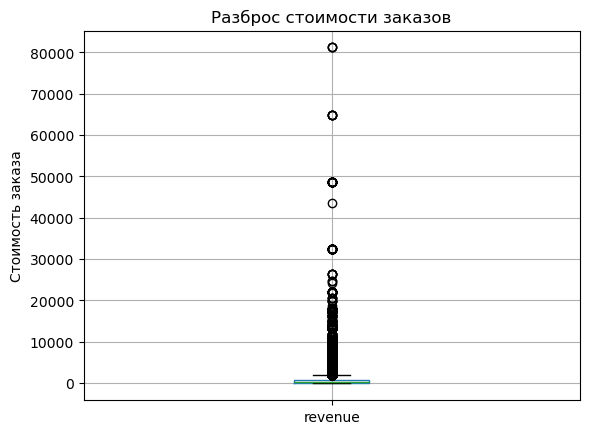

In [23]:
boxplot = df[['revenue']].boxplot()
boxplot.set_ylabel('Стоимость заказа')
boxplot.set_title('Разброс стоимости заказов')

In [24]:
boxplot = df[['tickets_count']].boxplot()
boxplot.set_ylabel('количества билетов')
boxplot.set_title('Разброс количества билетов в заказе')

Text(0.5, 1.0, 'Разброс количества билетов в заказе')

**Анализ данных позволяет сделать следующие выводы:**

Поле revenue:

* Обнаружены отрицательные значения, которые нецелесообразно учитывать в рамках данного анализа.

* Примерно 1 % покупателей приобретают билеты на сумму более 4 000 рублей. Хотя такие транзакции не являются ошибочными (вероятно, это коллективные покупки, оформленные на одного клиента), их потребуется исключить для корректности дальнейшего анализа.

Поле tickets_count:

* Данные выглядят достоверными и не вызывают вопросов.
* Основная масса значений сосредоточена в диапазоне до 20 билетов, а случаи приобретения большего количества билетов встречаются крайне редко.

In [25]:
df = df.drop(df[(df['revenue'] <=0) | (df['revenue'] > 4000.19)].index)
df = df.drop(df[(df['tickets_count'] > 20)].index)

In [26]:
display(df['revenue'].describe())

count    281547.000000
mean        549.671762
std         564.694694
min           0.020000
25%         125.770000
50%         362.670000
75%         805.305000
max        4000.190000
Name: revenue, dtype: float64

In [27]:
boxplot = df[['revenue']].boxplot()
boxplot.set_ylabel('Стоимость заказа')
boxplot.set_title('Разброс стоимости заказов')

Text(0.5, 1.0, 'Разброс стоимости заказов')

In [28]:
boxplot = df[['tickets_count']].boxplot()
boxplot.set_ylabel('Количества билетов')
boxplot.set_title('Разброс количества билетов в заказе')

Text(0.5, 1.0, 'Разброс количества билетов в заказе')

Приступаем к нормализации строковых данных

In [29]:
# Анализ категориальных значений
for column in ['device_type_canonical', 'event_id', 'event_name', 'event_type_main', 'service_name', 'city_name', 'region_name']:
    display(f"Column: {column}")
    display("Unique values:", df[column].unique())
    display("Missing values count:", df[column].isna().sum())
    display("Value counts:")
    display(df[column].value_counts(dropna=False))

'Column: device_type_canonical'

'Unique values:'

<StringArray>
['mobile', 'desktop']
Length: 2, dtype: string

'Missing values count:'

np.int64(0)

'Value counts:'

device_type_canonical
mobile     225819
desktop     55728
Name: count, dtype: Int64

'Column: event_id'

'Unique values:'

<StringArray>
['169230', '237325', '578454', '387271', '509453', '500862', '201953',
 '265857', '271579', '516728',
 ...
 '307447', '562123',  '65392', '257940', '358061',  '12820', '357588',
 '300765', '540339', '568852']
Length: 22049, dtype: string

'Missing values count:'

np.int64(0)

'Value counts:'

event_id
317299    2519
574431    1446
494565    1431
459673    1222
384441    1116
          ... 
578324       1
572553       1
591313       1
321226       1
562795       1
Name: count, Length: 22049, dtype: Int64

'Column: event_name'

'Unique values:'

<StringArray>
['f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad',
 '40efeb04-81b7-4135-b41f-708ff00cc64c',
 '01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca',
 '2f638715-8844-466c-b43f-378a627c419f',
 '10d805d3-9809-4d8a-834e-225b7d03f95d',
 '9cc55c15-4375-4129-9979-3129688ba1b4',
 '2f98d69f-4e60-4ffc-8f16-e539383526b1',
 '0d876e01-851e-458b-ba61-753e0e0c4063',
 'ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1',
 '11be386f-7cb7-4aa1-a8e4-ba73a29c1af2',
 ...
 'd3fe3298-9613-445a-aaf9-15cf03a242cc',
 'b508ef8b-526b-4f1c-9f57-96deba1d773f',
 '8d392c51-baeb-48af-8d77-bec526ece12d',
 'c56473e5-bc60-43fa-842c-89383777739a',
 'f5ed29fa-f5e5-4c8b-96ad-2e35c7e8342c',
 'aec82c6e-1155-4dd2-801a-e4b2ac9824a6',
 'f56f3d67-4673-4fb3-b202-3f2bfd39fcf6',
 'cf71bf2b-8e5c-47e0-a0f3-c2d4910c4677',
 'f17a01b7-3cd3-4cd1-919c-3459bd074886',
 '0fd6df8e-49e5-4337-954d-5a4606b1b899']
Length: 14938, dtype: string

'Missing values count:'

np.int64(0)

'Value counts:'

event_name
9cc55c15-4375-4129-9979-3129688ba1b4    3948
a00e1032-6463-4fdc-a105-fdbb6789b556    2519
0714435e-3b5f-4312-aa36-c3a9d8853ef4    1761
58574140-962c-49a3-af70-b773a05661a3    1743
e252d33a-2394-44b8-b11d-f0709a6f0260    1628
                                        ... 
6bf89774-a5e3-40c6-9941-748d94590453       1
09c355e1-cef0-4bfa-bbd5-b6608ec48c9d       1
26fa357c-eadf-4d97-8192-2dc38067e4f4       1
240b16e3-a04e-408d-8a47-ea58bdd9ade1       1
0040dc60-e8cf-4b97-8bb5-e72a3a367ca1       1
Name: count, Length: 14938, dtype: Int64

'Column: event_type_main'

'Unique values:'

<StringArray>
['театр', 'выставки', 'другое', 'стендап', 'концерты', 'ёлки', 'спорт']
Length: 7, dtype: string

'Missing values count:'

np.int64(0)

'Value counts:'

event_type_main
концерты    111852
театр        66826
другое       61333
спорт        21414
стендап      13325
выставки      4810
ёлки          1987
Name: count, dtype: Int64

'Column: service_name'

'Unique values:'

<StringArray>
[          'Край билетов',              'Мой билет',            'За билетом!',
            'Лови билет!',     'Билеты без проблем',                'Облачко',
          'Лучшие билеты',              'Прачечная',            'Быстробилет',
           'Дом культуры',         'Весь в билетах',          'Билеты в руки',
            'Тебе билет!',            'Show_ticket', 'Городской дом культуры',
                 'Яблоко',      'Билет по телефону',         'Выступления.ру',
               'Росбилет',        'Шоу начинается!',               'Мир касс',
              'Восьмёрка',              'Телебилет',          'Crazy ticket!',
                 'Реестр',         'Быстрый кассир',             'КарандашРУ',
           'Радио ticket',                'Дырокол',                'Вперёд!',
             'Кино билет',           'Цвет и билет',               'Зе Бест!',
              'Тех билет',                 'Лимоны',     'Билеты в интернете']
Length: 36, dtype: string

'Missing values count:'

np.int64(0)

'Value counts:'

service_name
Билеты без проблем        58088
Лови билет!               40801
Билеты в руки             39725
Мой билет                 32683
Облачко                   26557
Лучшие билеты             17646
Весь в билетах            16727
Прачечная                 10267
Край билетов               6195
Тебе билет!                5224
Яблоко                     5038
Дом культуры               4477
За билетом!                2861
Городской дом культуры     2733
Мир касс                   2166
Show_ticket                2148
Быстробилет                2002
Выступления.ру             1604
Восьмёрка                  1117
Crazy ticket!               790
Росбилет                    490
Шоу начинается!             490
Быстрый кассир              381
Радио ticket                376
Телебилет                   321
КарандашРУ                  133
Реестр                      125
Билет по телефону            85
Вперёд!                      80
Дырокол                      74
Кино билет                 

'Column: city_name'

'Unique values:'

<StringArray>
[   'Глиногорск',        'Озёрск',   'Родниковецк',   'Кристалевск',
 'Дальнозолотск',  'Радужнополье',        'Кумсай',     'Верховино',
    'Светополье',        'Кокжар',
 ...
     'Горноград',   'Березовцево',     'Берёзовка',   'Дальнозелен',
       'Травино',     'Карасуйск',      'Кызылжол',     'Поляновск',
     'Зареченец',     'Лесогорск']
Length: 351, dtype: string

'Missing values count:'

np.int64(0)

'Value counts:'

city_name
Глиногорск      84761
Озёрск          43677
Радужсвет       13275
Радужнополье     8741
Верховино        6572
                ...  
Озёроярск           1
Дальнеград          1
Травино             1
Берёзовка           1
Дальнозелен         1
Name: count, Length: 351, dtype: Int64

'Column: region_name'

'Unique values:'

<StringArray>
[       'Каменевский регион',      'Североярская область',
          'Озернинский край',      'Лугоградская область',
          'Поленовский край',       'Широковская область',
       'Златопольский округ',      'Малиновоярский округ',
       'Яблоневская область',         'Ветренский регион',
         'Боровлянский край',      'Крутоводская область',
      'Ягодиновская область',     'Серебряноярский округ',
          'Лесодальний край',       'Верхоречная область',
      'Горицветская область',       'Речиновская область',
         'Травиницкий округ',        'Сосновская область',
      'Серебринская область',         'Медовская область',
          'Травяная область',        'Каменноярский край',
   'Солнечноземская область',      'Светополянский округ',
          'Заречная область',         'Ручейковский край',
      'Глиногорская область',      'Тепляковская область',
       'Каменноозёрный край', 'Солнечнореченская область',
          'Зоринский регион',          'Ле

'Missing values count:'

np.int64(0)

'Value counts:'

region_name
Каменевский регион          86335
Североярская область        43816
Широковская область         16364
Медовская область           13465
Озернинский край            10474
                            ...  
Лесноярский край               19
Крутоводский регион            18
Верхозёрский край              11
Сосноводолинская область       10
Теплоозёрский округ             7
Name: count, Length: 81, dtype: Int64

**Краткий вывод по анализу категориальных признаков для предобработки данных**

*Пропуски*

Во всех анализируемых столбцах (device_type_canonical, event_id, event_name, event_type_main, service_name, city_name, region_name) пропусков нет (Missing values count: 0).

*Ключевые наблюдения по столбцам*

* device_type_canonical: всего 2 категории (mobile, desktop). Можно оставить как есть или преобразовать в bool (0/1).
* event_id и event_name: очень высокая кардинальность (22 049 и 14 938 уникальных значений). Вероятно, это идентификаторы событий. Для анализа лучше использовать event_type_main.
* event_type_main: 7 понятных категорий (театр, выставки, другое и др.). Готов к использованию в анализе.
* service_name: 36 сервисов с сильным перекосом в частотах (например, «Билеты без проблем» — 58 088, а «Билеты в интернете» — 4). Можно:
    * оставить как есть;
    * сгруппировать редкие сервисы в категорию «другие»;
    * отобрать топ‑N сервисов для анализа.
* city_name: 351 город с явным доминированием («Глиногорск» — 84 761, многие города — по 1 записи). Варианты:
    * агрегировать в «крупные/малые города»;
    * оставить только топ‑городов;
    * использовать на уровне регионов.
* region_name: 81 регион с неравномерным распределением (топ‑1: «Каменевский регион» — 86 335, многие — по 10–20 записей). Можно:
    * работать на уровне регионов;
    * объединить редкие регионы в «прочие».

*Варианты для предобработки:*

* Оставить без изменений: device_type_canonical, event_type_main (уже удобны для анализа).
* Сократить кардинальность:
    * event_id, event_name — не использовать напрямую, опираться на event_type_main;
    * service_name — сгруппировать редкие значения;
    * city_name — агрегировать или отобрать топ‑городов;
    * region_name — рассмотреть объединение редких регионов.

* Проверить дисбаланс: в service_name, city_name, region_name есть сильно доминирующие категории 

In [30]:
# проверка на уникальность если order_id = длине df то в каждой строке уникальный id заказа 
display(df['order_id'].nunique())
display(len(df['order_id']))

281547

281547

In [31]:
display(f"В датасете было 290611 строк, теперь {len(df['order_id'])} строк. Потери в данных {round((290611 - len(df['order_id']))/290611*100,2)}%, критичным не является.")

'В датасете было 290611 строк, теперь 281547 строк. Потери в данных 3.12%, критичным не является.'

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [32]:
#Проводим сортировку по времени совершения заказа.
df = df.sort_values(['user_id', 'order_ts'])

In [33]:
# Создаем профиль пользователя
user_profile = df.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'),  # дата первого заказа
    last_order_dt=('order_dt', 'max'),   # дата последнего заказа
    first_device=('device_type_canonical', 'first'),  # устройство первого заказа
    first_region=('region_name', 'first'),  # регион первого заказа
    first_service=('service_name', 'first'),  # билетный партнер первого заказа
    first_event_type=('event_type_main', 'first'),  # жанр первого мероприятия
    total_orders=('order_id', 'count'),  # общее количество заказов
    avg_revenue_rub=('revenue_rub', 'mean'),  # средняя выручка в рублях
    avg_tickets=('tickets_count', 'mean'),  # среднее количество билетов
    avg_days_between=('days_since_prev', 'mean')  # среднее время между заказами
).reset_index()

# Добавляем бинарные признаки
user_profile['is_two'] = ((user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

# Просмотрим результат
display(f"Всего пользователей: {len(user_profile)}")
user_profile.head()

'Всего пользователей: 21608'

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


In [34]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21608 entries, 0 to 21607
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           21608 non-null  string        
 1   first_order_dt    21608 non-null  datetime64[ns]
 2   last_order_dt     21608 non-null  datetime64[ns]
 3   first_device      21608 non-null  string        
 4   first_region      21608 non-null  string        
 5   first_service     21608 non-null  string        
 6   first_event_type  21608 non-null  string        
 7   total_orders      21608 non-null  int64         
 8   avg_revenue_rub   21551 non-null  float64       
 9   avg_tickets       21608 non-null  float64       
 10  avg_days_between  13423 non-null  float64       
 11  is_two            21608 non-null  int64         
 12  is_five           21608 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(3), string(5)
memory usage: 2.1 MB


Наличие NaN в avg_days_between свидетельствует об единственном заказе пользователя. Тип данных поля user_id нужно изменить на строковый.

In [35]:
user_profile['user_id'] = user_profile['user_id'].astype("string")

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [36]:
# Общее число пользователей
display(f"1. Общее число пользователей в выборке: {len(user_profile)}")

'1. Общее число пользователей в выборке: 21608'

In [37]:
# Средняя выручка с одного заказа
display(f"2. Средняя выручка с одного заказа: {user_profile['avg_revenue_rub'].mean():.2f} руб.")

'2. Средняя выручка с одного заказа: 569.66 руб.'

In [38]:
# Доля пользователей с ≥2 заказами (используем готовый флаг is_two)
share_2plus = user_profile['is_two'].mean()
print(f"3. Доля пользователей с 2+ заказами: {share_2plus:.2%}")

3. Доля пользователей с 2+ заказами: 32.77%


In [39]:
# Доля пользователей с ≥5 заказами (используем готовый флаг is_five)
share_5plus = user_profile['is_five'].mean()
print(f"4. Доля пользователей с 5+ заказами: {share_5plus:.2%}")

4. Доля пользователей с 5+ заказами: 28.96%


In [40]:
# Выводим основные статистики
cols = ['total_orders', 'avg_tickets', 'avg_days_between']
stats = user_profile[cols].describe()
print("\n1. Статистические показатели:")
print(stats)

# Дополнительно: медиана и IQR
print("\n2. Дополнительные статистики (медиана, IQR):")
for col in cols:
    median = user_profile[col].median()
    q1 = user_profile[col].quantile(0.25)
    q3 = user_profile[col].quantile(0.75)
    iqr = q3 - q1
    print(f"{col}: медиана={median:.2f}, IQR={iqr:.2f}")



1. Статистические показатели:
       total_orders   avg_tickets  avg_days_between
count  21608.000000  21608.000000      13423.000000
mean      13.029757      2.751311         16.003417
std      120.169466      0.922880         22.453112
min        1.000000      1.000000          0.000000
25%        1.000000      2.000000          1.000000
50%        2.000000      2.750000          8.133333
75%        5.000000      3.125000         20.800000
max    10013.000000     11.000000        148.000000

2. Дополнительные статистики (медиана, IQR):
total_orders: медиана=2.00, IQR=4.00
avg_tickets: медиана=2.75, IQR=1.12
avg_days_between: медиана=8.13, IQR=19.80


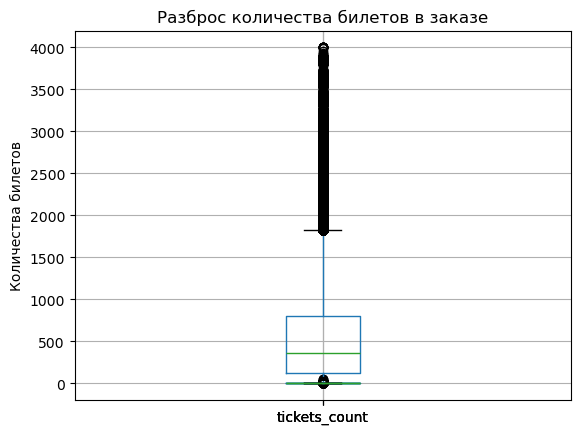

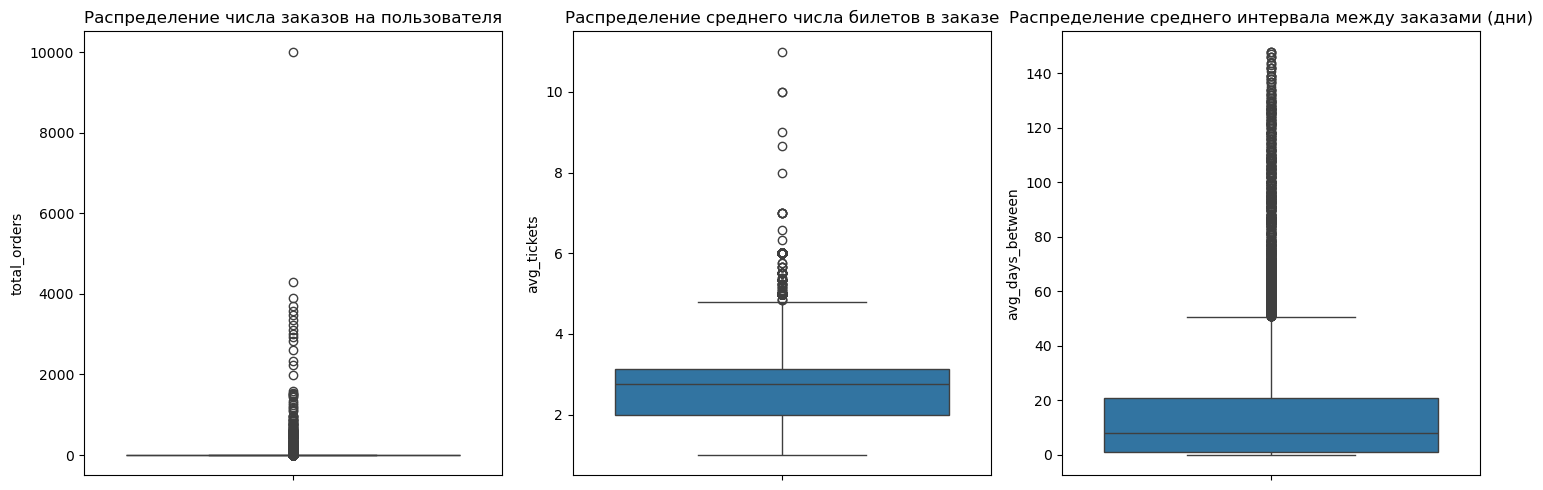

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=user_profile['total_orders'], ax=axes[0])
axes[0].set_title('Распределение числа заказов на пользователя')

sns.boxplot(data=user_profile['avg_tickets'], ax=axes[1])
axes[1].set_title('Распределение среднего числа билетов в заказе')


sns.boxplot(data=user_profile['avg_days_between'], ax=axes[2])
axes[2].set_title('Распределение среднего интервала между заказами (дни)')


plt.tight_layout()
plt.show()


In [42]:
def detect_outliers(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound


outliers_orders, lb_o, ub_o = detect_outliers(user_profile['total_orders'])
outliers_tickets, lb_t, ub_t = detect_outliers(user_profile['avg_tickets'])
outliers_days, lb_d, ub_d = detect_outliers(user_profile['avg_days_between'])


print("\n3. Выявление аномалий (k=1.5 * IQR):")
print(f"Число заказов: {len(outliers_orders)} выбросов (границы: [{lb_o:.0f}, {ub_o:.0f}]), max={user_profile['total_orders'].max()}")
print(f"Билеты в заказе: {len(outliers_tickets)} выбросов (границы: [{lb_t:.2f}, {ub_t:.2f}]), max={user_profile['avg_tickets'].max():.2f}")
print(f"Дни между заказами: {len(outliers_days)} выбросов (границы: [{lb_d:.1f}, {ub_d:.1f}]), max={user_profile['avg_days_between'].max():.1f}")



3. Выявление аномалий (k=1.5 * IQR):
Число заказов: 2711 выбросов (границы: [-5, 11]), max=10013
Билеты в заказе: 683 выбросов (границы: [0.31, 4.81]), max=11.00
Дни между заказами: 979 выбросов (границы: [-28.7, 50.5]), max=148.0


**Число заказов:**
* Обнаружено 2 711 выбросов (12,5 % от всей выборки).

* Верхняя граница нормы по IQR: 11 заказов.

* Максимальное значение: 10 013 заказов (явный выброс).

* Интерпретация: *есть пользователи с экстремально высокой частотой покупок, сильно отклоняющиеся от типичного поведения.*

**Билеты в заказе:**

* 683 выброса (3,2 % выборки).

* Границы нормы: 0,31–4,81 билета.

* Максимум: 11 билетов (вдвое выше верхней границы).

* Интерпретация: *редкие заказы с необычно большим числом билетов.*

**Дни между заказами:**

* 979 выбросов (4,5 % выборки).

* Границы: −28,7 – 50,5 дней (отрицательное значение указывает на потенциальную ошибку в датах).

* Максимум: 148 дней (почти в 3 раза выше верхней границы).

* Интерпретация: *часть пользователей делает заказы с очень длинными перерывами; отрицательные значения требуют проверки.* 

**Оценка репрезентативности данных**

Объём выборки достаточен (21 608 пользователей).

Аномалии присутствуют во всех ключевых метриках, но их доля умеренная (3,2–12,5 %).

**Причины аномалий** 

Число заказов: возможно, боты, оптовые закупки или ошибки учёта.

Билеты в заказе: групповые заказы или ввод данных с опечатками.

Дни между заказами:
   * Отрицательные значения — вероятная ошибка в датах (first_order_dt > last_order_dt).

   * Высокие положительные значения — реальные «спящие» клиенты
   

In [43]:
# избавляемся от тех, кто портит статистику, оставляем данные не выше 99 процентиля
user_profile = user_profile[user_profile['total_orders'] <= user_profile['total_orders'].quantile(0.99)]

print(user_profile['total_orders'].describe())

boxplot = user_profile[['total_orders']].boxplot()
boxplot.set_ylabel('Количество заказов')
boxplot.set_title('Распределение числа заказов на пользователя')

count    21391.000000
mean         6.406760
std         13.961665
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        149.000000
Name: total_orders, dtype: float64


Text(0.5, 1.0, 'Распределение числа заказов на пользователя')

In [44]:
# Ищем отрицательные значения
negative_days = user_profile[user_profile['avg_days_between'] < 0]
if len(negative_days) > 0:
    print("Найденны отрицательные значения avg_days_between:")
    print(negative_days[['user_id', 'avg_days_between']])
else:
    print("Отрицательных значений в avg_days_between нет.")



Отрицательных значений в avg_days_between нет.


In [45]:
print("Статистика после очистки:")
print(user_profile[['total_orders', 'avg_tickets', 'avg_days_between']].describe())

Статистика после очистки:
       total_orders   avg_tickets  avg_days_between
count  21391.000000  21391.000000      13206.000000
mean       6.406760      2.751423         16.258810
std       13.961665      0.927392         22.547520
min        1.000000      1.000000          0.000000
25%        1.000000      2.000000          1.369159
50%        2.000000      2.750000          8.500000
75%        5.000000      3.142857         21.000000
max      149.000000     11.000000        148.000000


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [46]:
# Общее число пользователей
total_users = len(user_profile)
print(f"Общее число пользователей: {total_users}\n")


Общее число пользователей: 21391



In [47]:
event_type_group = user_profile['first_event_type'].value_counts().reset_index()
event_type_group.columns = ['Тип мероприятия', 'Количество пользователей']
event_type_group['Доля (%)'] = (event_type_group['Количество пользователей'] / total_users * 100)


print("1. Распределение по типу первого мероприятия:")
print(event_type_group)
print(f"\nВсего категорий: {len(event_type_group)}")

1. Распределение по типу первого мероприятия:
  Тип мероприятия  Количество пользователей   Доля (%)
0        концерты                      9416  44.018512
1          другое                      5273  24.650554
2           театр                      4299  20.097237
3         стендап                      1124   5.254546
4           спорт                       769    3.59497
5        выставки                       413   1.930719
6            ёлки                        97   0.453462

Всего категорий: 7


In [48]:
device_group = user_profile['first_device'].value_counts().reset_index()
device_group.columns = ['Устройство', 'Количество пользователей']
device_group['Доля (%)'] = (device_group['Количество пользователей'] / total_users * 100)

print("\n2. Распределение по устройству первой покупки:")
print(device_group)
print(f"\nВсего категорий: {len(device_group)}")



2. Распределение по устройству первой покупки:
  Устройство  Количество пользователей   Доля (%)
0     mobile                     17740  82.932074
1    desktop                      3651  17.067926

Всего категорий: 2


In [49]:
region_group = user_profile['first_region'].value_counts().reset_index()
region_group.columns = ['Регион', 'Количество пользователей']
region_group['Доля (%)'] = (region_group['Количество пользователей'] / total_users * 100)


print("\n3. Распределение по региону первого мероприятия:")
print(region_group)
print(f"\nВсего регионов: {len(region_group)}")



3. Распределение по региону первого мероприятия:
                      Регион  Количество пользователей   Доля (%)
0         Каменевский регион                      7039  32.906362
1       Североярская область                      3808  17.801879
2        Широковская область                      1249   5.838904
3           Озернинский край                       686   3.206956
4       Малиновоярский округ                       543   2.538451
..                       ...                       ...        ...
76         Светолесский край                         2    0.00935
77       Тихогорская область                         2    0.00935
78  Сосноводолинская область                         1   0.004675
79        Яснопольский округ                         1   0.004675
80         Верхозёрский край                         1   0.004675

[81 rows x 3 columns]

Всего регионов: 81


In [50]:
service_group = user_profile['first_service'].value_counts().reset_index()
service_group.columns = ['Оператор', 'Количество пользователей']
service_group['Доля (%)'] = (service_group['Количество пользователей'] / total_users * 100)


print("\n4. Распределение по билетному оператору:")
print(service_group)
print(f"\nВсего операторов: {len(service_group)}")



4. Распределение по билетному оператору:
                  Оператор  Количество пользователей   Доля (%)
0       Билеты без проблем                      4973  23.248095
1              Лови билет!                      2826  13.211164
2                Мой билет                      2778   12.98677
3            Билеты в руки                      2557  11.953625
4                  Облачко                      2216  10.359497
5           Весь в билетах                      1312   6.133421
6            Лучшие билеты                      1190   5.563087
7                Прачечная                       596   2.786219
8             Край билетов                       464   2.169137
9             Дом культуры                       360   1.682951
10                  Яблоко                       320   1.495956
11             Тебе билет!                       312   1.458557
12  Городской дом культуры                       220    1.02847
13                Мир касс                       211   0.98639

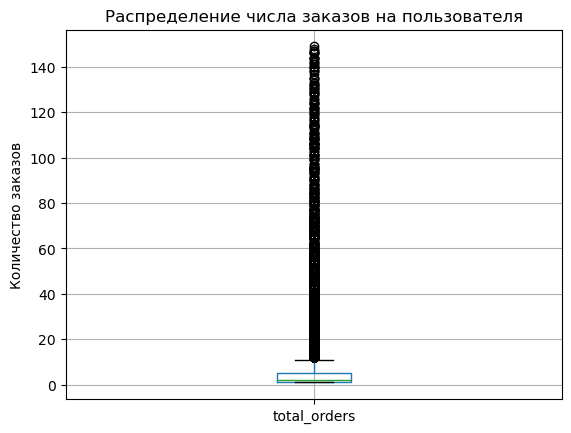

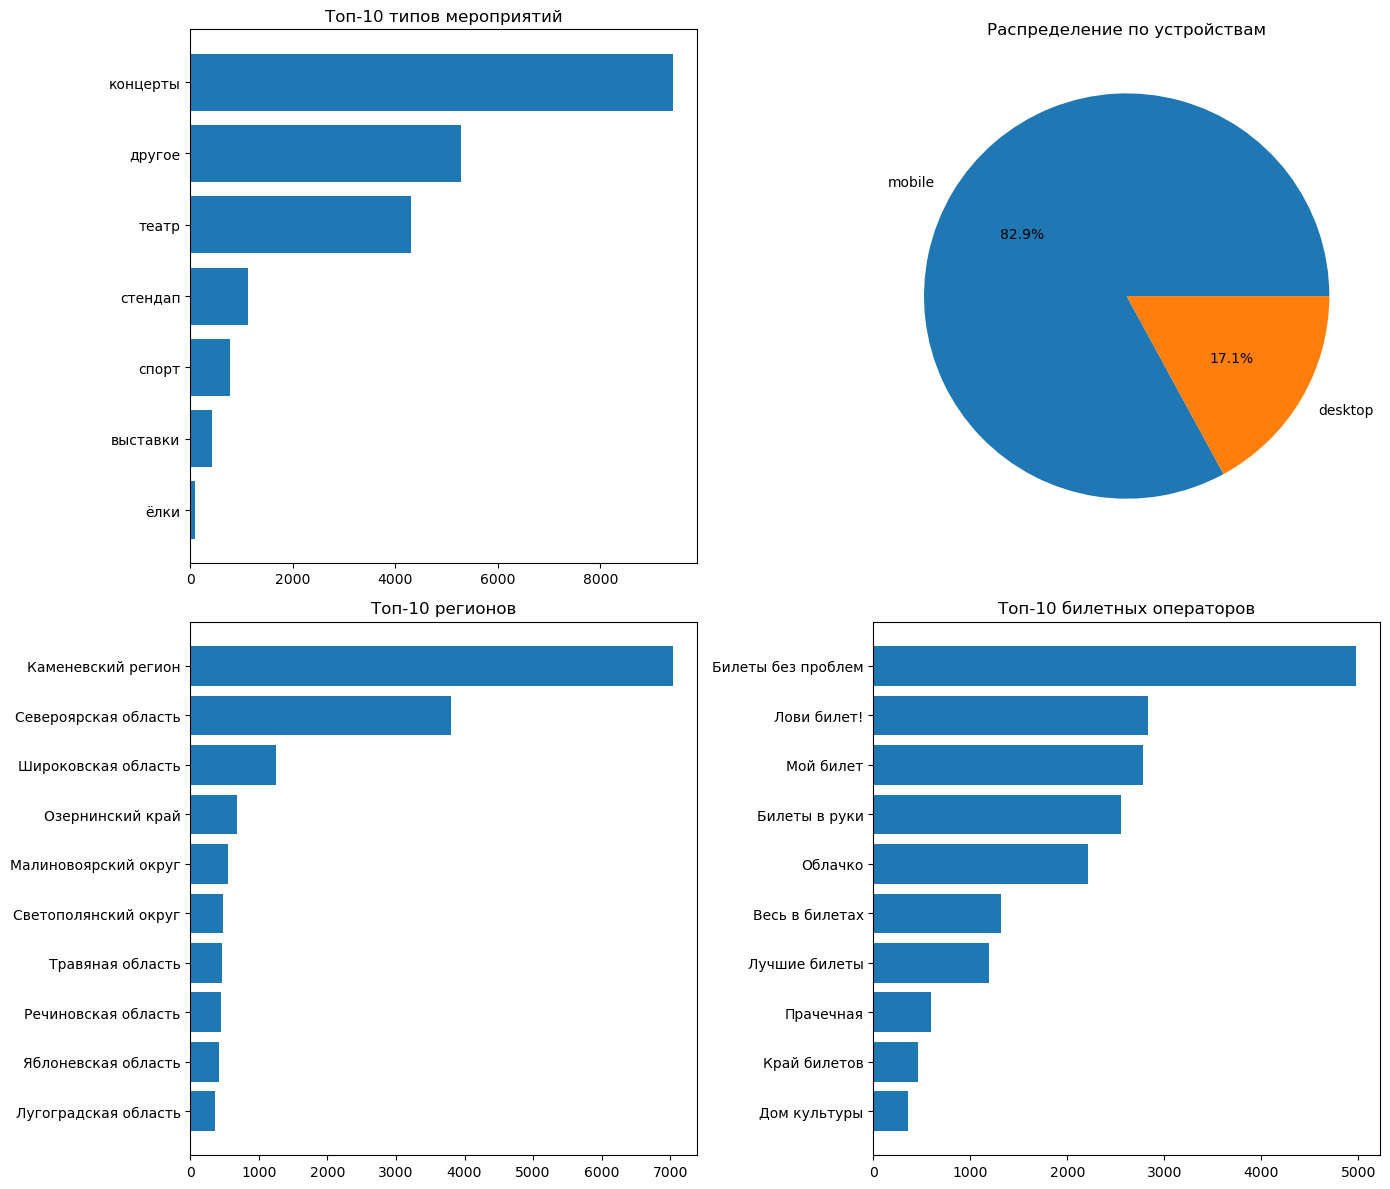

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))


# 1. Тип мероприятия (топ-10)
top_events = event_type_group.head(10)
axes[0, 0].barh(top_events['Тип мероприятия'], top_events['Количество пользователей'])
axes[0, 0].set_title('Топ-10 типов мероприятий')
axes[0, 0].invert_yaxis()


# 2. Устройство
axes[0, 1].pie(device_group['Количество пользователей'], labels=device_group['Устройство'], autopct='%1.1f%%')
axes[0, 1].set_title('Распределение по устройствам')


# 3. Регион (топ-10)
top_regions = region_group.head(10)
axes[1, 0].barh(top_regions['Регион'], top_regions['Количество пользователей'])
axes[1, 0].set_title('Топ-10 регионов')
axes[1, 0].invert_yaxis()


# 4. Оператор (топ-10)
top_services = service_group.head(10)
axes[1, 1].barh(top_services['Оператор'], top_services['Количество пользователей'])
axes[1, 1].set_title('Топ-10 билетных операторов')
axes[1, 1].invert_yaxis()


plt.tight_layout()
plt.show()


In [52]:
def gini_index(x):
    n = len(x)
    x_sorted = sorted(x)
    B = sum(xi * (n - i) for i, xi in enumerate(x_sorted))
    return 1 - 2 * B / (n * sum(x))


print("\n5. Оценка равномерности (индекс Джини):")
for name, data in zip(
    ['Тип мероприятия', 'Устройство', 'Регион', 'Оператор'],
    [event_type_group, device_group, region_group, service_group]
):
    gini = gini_index(data['Количество пользователей'].values)
    print(f"{name}: {gini:.3f}")



5. Оценка равномерности (индекс Джини):
Тип мероприятия: 0.408
Устройство: -0.171
Регион: 0.780
Оператор: 0.720


**Выводы по распределению пользователей по сегментам**

Ни один из признаков не демонстрирует равномерного распределения. Во всех категориях есть выраженные «точки входа».

Самые значимые точки входа по признакам:

Тип мероприятия: концерты (44 %).

Устройство: mobile (82,9 %).

Регион: Каменевский регион (32,9 %).

Оператор: «Билеты без проблем» (23,2 %).

Концентрация пользователей:

В топ‑2 сегментов по типу мероприятия — 68,7 %.

В топ‑2 регионов — 50,7 %.

В топ‑3 операторов — 49,4 %.


---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [53]:
# Доля возвращающихся пользователей в целом по выборке
overall_return_rate = user_profile['is_two'].mean()
print(f"Средняя доля возвращающихся (2+ заказа) по всей выборке: {overall_return_rate:.1%}")

Средняя доля возвращающихся (2+ заказа) по всей выборке: 33.1%


In [54]:
event_return = (
    user_profile
    .groupby('first_event_type')
    .agg({'is_two': 'mean', 'user_id': 'count'})
    .reset_index()
)
event_return.columns = ['first_event_type', 'return_rate', 'n_users']
event_return['return_rate'] = event_return['return_rate'].round(3)
print("\nДоля возвращающихся по типу мероприятия:")
print(event_return.sort_values('return_rate', ascending=False))



Доля возвращающихся по типу мероприятия:
  first_event_type  return_rate  n_users
0         выставки        0.373      413
6             ёлки        0.371       97
5            театр        0.340     4299
4          стендап        0.334     1124
2         концерты        0.334     9416
3            спорт        0.328      769
1           другое        0.314     5273


In [55]:
device_return = (
    user_profile
    .groupby('first_device')
    .agg({'is_two': 'mean', 'user_id': 'count'})
    .reset_index()
)
device_return.columns = ['first_device', 'return_rate', 'n_users']
device_return['return_rate'] = device_return['return_rate'].round(3)
print("\nДоля возвращающихся по устройству:")
print(device_return.sort_values('return_rate', ascending=False))



Доля возвращающихся по устройству:
  first_device  return_rate  n_users
1       mobile        0.331    17740
0      desktop        0.329     3651


In [56]:
region_return = (
    user_profile
    .groupby('first_region')
    .agg({'is_two': 'mean', 'user_id': 'count'})
    .reset_index()
)
region_return.columns = ['first_region', 'return_rate', 'n_users']
region_return['return_rate'] = region_return['return_rate'].round(3)


# Топ‑10 регионов по числу пользователей
top_regions = region_return.nlargest(10, 'n_users')
print("\nДоля возвращающихся по региону (топ‑10):")
print(top_regions.sort_values('return_rate', ascending=False))



Доля возвращающихся по региону (топ‑10):
            first_region  return_rate  n_users
77   Широковская область        0.371     1249
57  Светополянский округ        0.369      472
45      Озернинский край        0.356      686
78   Яблоневская область        0.355      414
52   Речиновская область        0.352      446
60  Североярская область        0.337     3808
23    Каменевский регион        0.326     7039
74      Травяная область        0.323      462
41  Малиновоярский округ        0.313      543
39  Лугоградская область        0.294      364


In [57]:
service_return = (
    user_profile
    .groupby('first_service')
    .agg({'is_two': 'mean', 'user_id': 'count'})
    .reset_index()
)
service_return.columns = ['first_service', 'return_rate', 'n_users']
service_return['return_rate'] = service_return['return_rate'].round(3)


# Топ‑10 операторов по числу пользователей
top_services = service_return.nlargest(10, 'n_users')
print("\nДоля возвращающихся по оператору (топ‑10):")
print(top_services.sort_values('return_rate', ascending=False))



Доля возвращающихся по оператору (топ‑10):
         first_service  return_rate  n_users
12        Дом культуры        0.364      360
7       Весь в билетах        0.354     1312
23             Облачко        0.345     2216
20       Лучшие билеты        0.343     1190
19         Лови билет!        0.329     2826
22           Мой билет        0.328     2778
4        Билеты в руки        0.325     2557
3   Билеты без проблем        0.316     4973
17        Край билетов        0.306      464
24           Прачечная        0.300      596


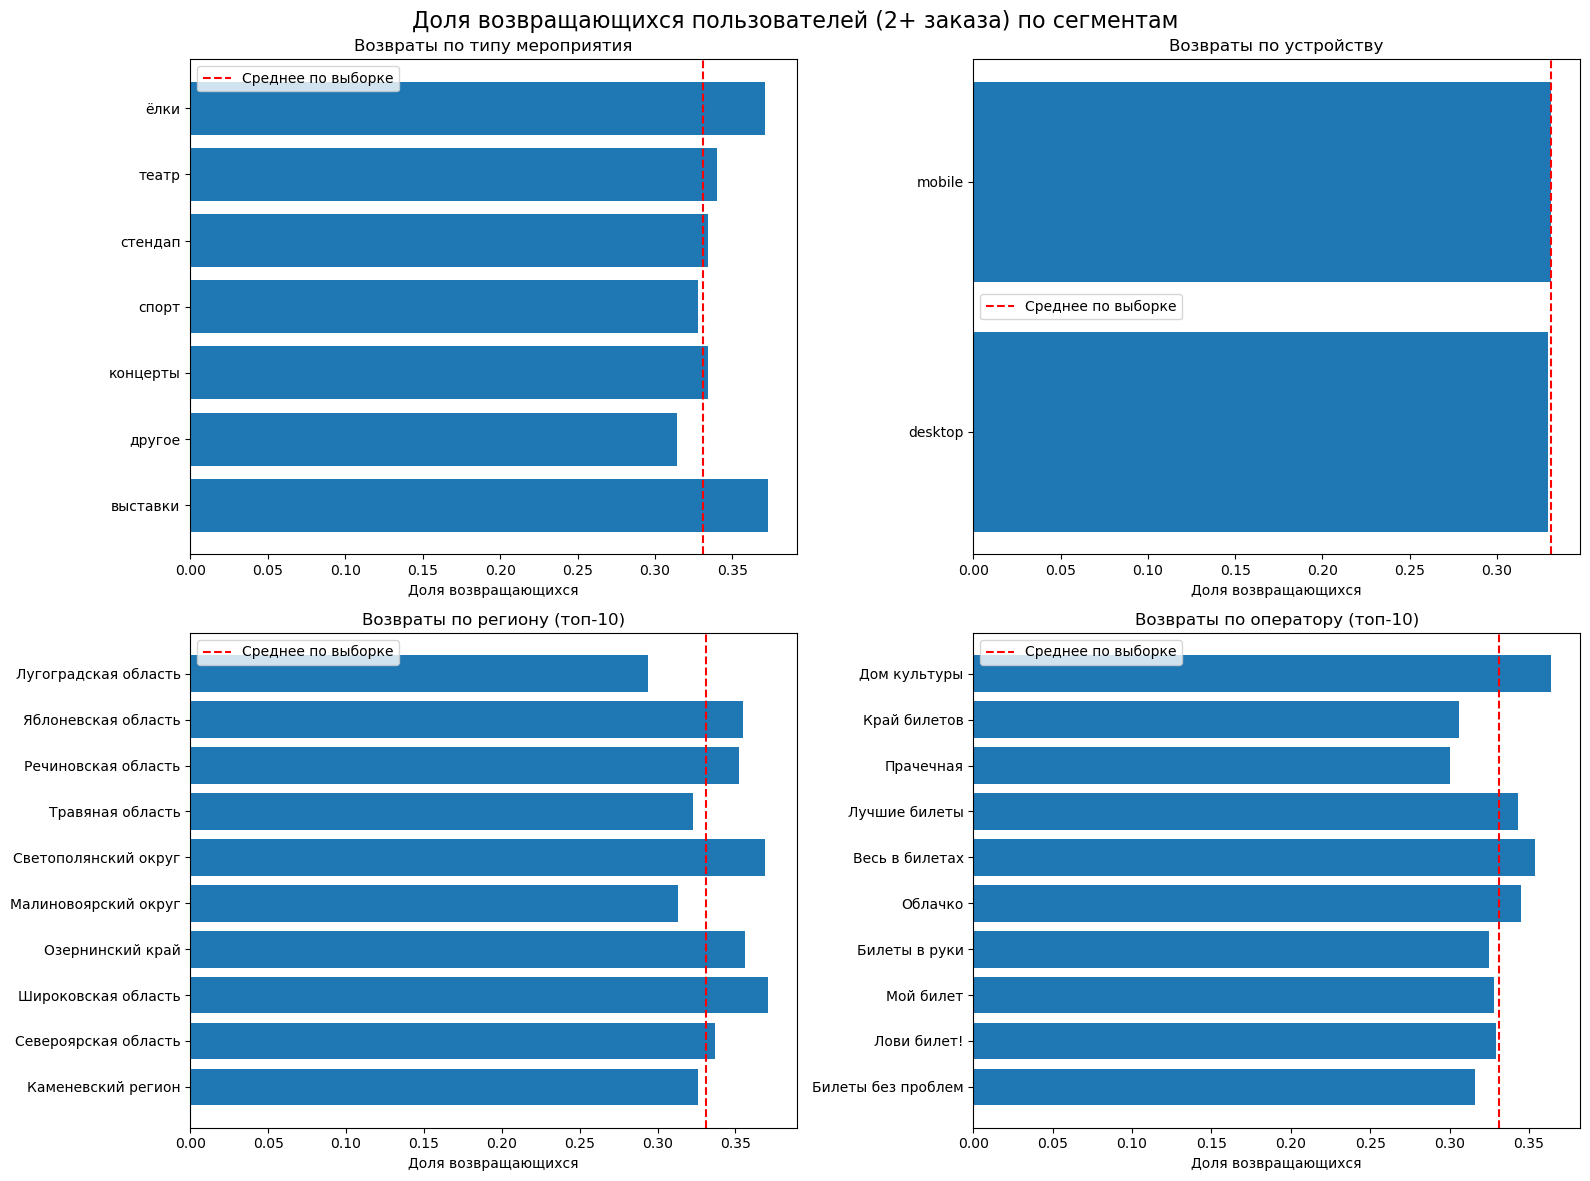

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


# а) Тип мероприятия
axes[0, 0].barh(event_return['first_event_type'], event_return['return_rate'])
axes[0, 0].axvline(overall_return_rate, color='red', linestyle='--', label='Среднее по выборке')
axes[0, 0].set_xlabel('Доля возвращающихся')
axes[0, 0].set_title('Возвраты по типу мероприятия')
axes[0, 0].legend()


# б) Устройство
axes[0, 1].barh(device_return['first_device'], device_return['return_rate'])
axes[0, 1].axvline(overall_return_rate, color='red', linestyle='--', label='Среднее по выборке')
axes[0, 1].set_xlabel('Доля возвращающихся')
axes[0, 1].set_title('Возвраты по устройству')
axes[0, 1].legend()


# в) Регион (топ‑10)
axes[1, 0].barh(top_regions['first_region'], top_regions['return_rate'])
axes[1, 0].axvline(overall_return_rate, color='red', linestyle='--', label='Среднее по выборке')
axes[1, 0].set_xlabel('Доля возвращающихся')
axes[1, 0].set_title('Возвраты по региону (топ‑10)')
axes[1, 0].legend()


# г) Оператор (топ‑10)
axes[1, 1].barh(top_services['first_service'], top_services['return_rate'])
axes[1, 1].axvline(overall_return_rate, color='red', linestyle='--', label='Среднее по выборке')
axes[1, 1].set_xlabel('Доля возвращающихся')
axes[1, 1].set_title('Возвраты по оператору (топ‑10)')
axes[1, 1].legend()


plt.suptitle("Доля возвращающихся пользователей (2+ заказа) по сегментам", fontsize=16)
plt.tight_layout()
plt.show()


Ответы на вопросы:

Сегменты с наиболее высокой долей возвратов (существенно выше 33,1 %):

по типу мероприятия: выставки, ёлки, театр;

по региону: Широковская область, Светополянский округ, Озернинский край, Яблоневская область, Речиновская область;

по оператору: Дом культуры, Весь в билетах, Облачко, Лучшие билеты.

Стабильные «точки входа» (большой объём + высокий возврат):

театр (4 299 чел., 34,0 %);

Широковская область (1 249 чел., 37,1 %);

Весь в билетах (1 312 чел., 35,4 %);

Облачко (2 216 чел., 34,5 %).

Факторы, не влияющие на возврат:

тип устройства (mobile/desktop): различия минимальны.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [59]:
# Фильтруем пользователей по типу первого мероприятия
sport_users = user_profile[user_profile['first_event_type'] == 'спорт']
concert_users = user_profile[user_profile['first_event_type'] == 'концерты']

# Доля возвращающихся (is_two = 1) в каждом сегменте
sport_return_rate = sport_users['is_two'].mean()
concert_return_rate = concert_users['is_two'].mean()

print(f"Доля возвращающихся среди пользователей, начавших с спорта: {sport_return_rate:.1%}")
print(f"Доля возвращающихся среди пользователей, начавших с концертов: {concert_return_rate:.1%}")


Доля возвращающихся среди пользователей, начавших с спорта: 32.8%
Доля возвращающихся среди пользователей, начавших с концертов: 33.4%


**Вывод по Гипотезе 1.** 

Не подтверждается.

Пользователи, начавшие с спортивных мероприятий, не возвращаются чаще, чем начавшие с концертов.

Доля возвратов: 32,8 % vs 33,4 % — разница минимальна и статистически не значима.

Концерты даже слегка опережают спорт, но эффект пренебрежимо мал.






**Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

Шаг 1. Определяем «активные» и «менее активные» регионы

«Активные» — топ‑3 региона по числу пользователей: 'Озернинский край', 'Североярская область', 'Широковская область'

«Менее активные» — регионы вне топ‑3 (остальные 78 регионов).

Шаг 2. Считаем долю возвратов в группах

In [60]:
# Группируем по региону и считаем:
# - общее число пользователей в регионе
# - число пользователей с 2+ заказами
region_return = user_profile.groupby('first_region').agg(
    total_users=('user_id', 'count'),
    returning_users=('is_two', 'sum')  # is_two == 1 означает 2+ заказа
).reset_index()

# Вычисляем долю возвратов
region_return['return_rate'] = region_return['returning_users'] / region_return['total_users']

# Сортируем по числу пользователей (актиивности)
region_return = region_return.sort_values('total_users', ascending=False)


In [61]:
N = 5
top_regions = region_return.head(N)['first_region'].tolist()


# Метки: 1 — активный регион, 0 — менее активный
user_profile['is_top_region'] = user_profile['first_region'].isin(top_regions).astype(int)


In [62]:
# Группируем по метке «топ-регион» и считаем долю возвратов
comparison = user_profile.groupby('is_top_region').agg(
    total_users=('user_id', 'count'),
    returning_users=('is_two', 'sum')
).reset_index()

comparison['return_rate'] = comparison['returning_users'] / comparison['total_users']


print("Сравнение долей возвратов:")
print(comparison)


Сравнение долей возвратов:
   is_top_region  total_users  returning_users  return_rate
0              0         8066             2628     0.325812
1              1        13325             4452     0.334109


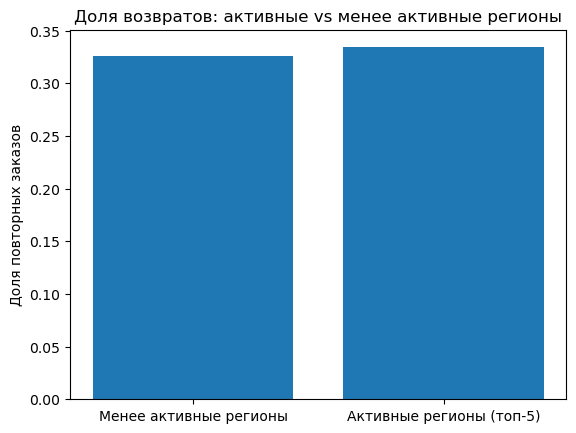

In [63]:
labels = ['Менее активные регионы', 'Активные регионы (топ‑5)']
rates = comparison['return_rate'].tolist()


plt.bar(labels, rates)
plt.ylabel('Доля повторных заказов')
plt.title('Доля возвратов: активные vs менее активные регионы')
plt.show()


In [64]:
# Данные для теста
count = [comparison.loc[comparison['is_top_region'] == 1, 'returning_users'].values[0],
         comparison.loc[comparison['is_top_region'] == 0, 'returning_users'].values[0]]
nobs = [comparison.loc[comparison['is_top_region'] == 1, 'total_users'].values[0],
        comparison.loc[comparison['is_top_region'] == 0, 'total_users'].values[0]]


# Z‑тест (односторонний: H₁ — доля в топ‑регионах выше)
zstat, pval = proportions_ztest(count, nobs, alternative='larger')


print(f"z‑статистика: {zstat:.3f}")
print(f"p‑значение: {pval:.4f}")


z‑статистика: 1.250
p‑значение: 0.1057


Доля повторных заказов в топ‑5 регионах (33,4 %) не отличается значимо от остальных регионов (32,6 %), p = 0,10. **Гипотеза не подтверждается.**

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


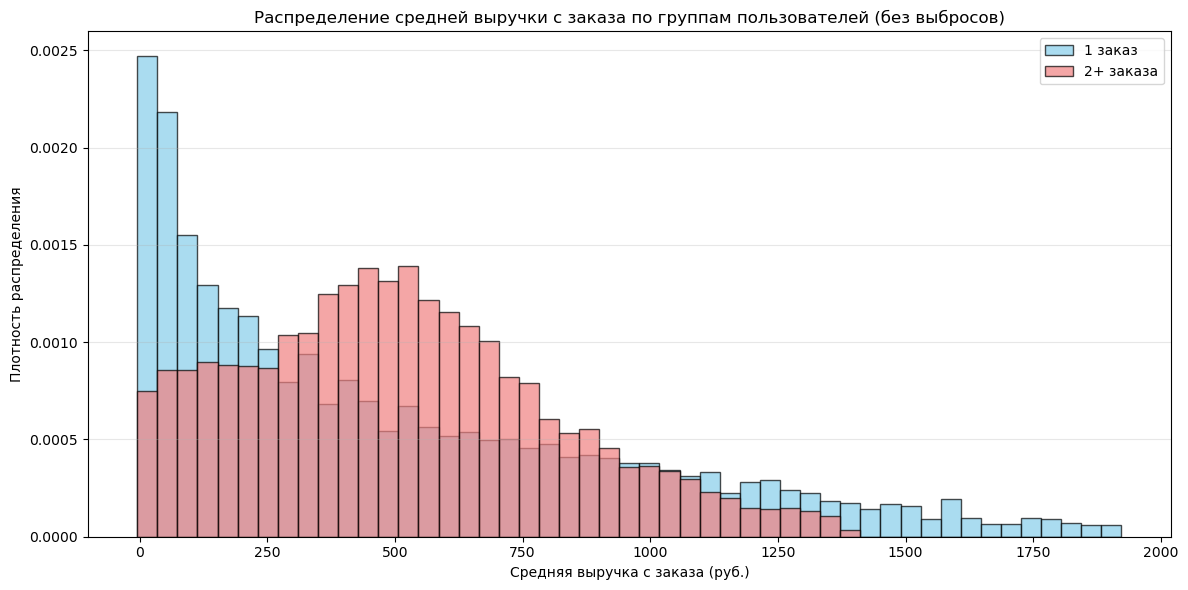

АНАЛИЗ РАСПРЕДЕЛЕНИЯ СРЕДНЕЙ ВЫРУЧКИ ПО ГРУППАМ
1. В каких диапазонах средней выручки концентрируются пользователи?

Группа «1 заказ» (очищенные данные):
- Медиана: 358.53 руб.
- Межквартильный размах (25–75%): 117.20 – 788.90 руб.
- Диапазон значений: -4.81 – 1,922.81 руб.

Группа «2+ заказа» (очищенные данные):
- Медиана: 487.92 руб.
- Межквартильный размах (25–75%): 284.81 – 700.09 руб.
- Диапазон значений: -3.21 – 1,382.20 руб.

2. Есть ли различия между группами?

Ключевые различия:
- Медиана у «2+ заказов» выше на 36.1%
- Среднее у «2+ заказов» выше на 2.1%
- Разброс (std) у «2+ заказов» меньше на 33.5%



In [65]:
# 1. Разделение на группы и очистка от пропусков
single_order = user_profile[user_profile['total_orders'] == 1]['avg_revenue_rub'].dropna()
returning_users = user_profile[user_profile['total_orders'] >= 2]['avg_revenue_rub'].dropna()


# 2. Функция для удаления выбросов по методу IQR
def filter_outliers_iqr(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    filtered = series[(series >= lower) & (series <= upper)]
    return filtered, (lower, upper)


# 3. Очистка данных
filtered_single, bounds_single = filter_outliers_iqr(single_order)
filtered_returning, bounds_returning = filter_outliers_iqr(returning_users)


# 4. Вычисление описательной статистики
stats_single = filtered_single.describe()
stats_returning = filtered_returning.describe()


# 5. Построение сравнительных гистограмм
plt.figure(figsize=(12, 6))


# Общие бины для обеих групп
all_values = pd.concat([filtered_single, filtered_returning])
bins = np.linspace(all_values.min(), all_values.max(), 50)


plt.hist(filtered_single, bins=bins, alpha=0.7, label='1 заказ',
        color='skyblue', density=True, edgecolor='black')
plt.hist(filtered_returning, bins=bins, alpha=0.7, label='2+ заказа',
        color='lightcoral', density=True, edgecolor='black')


plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа по группам пользователей (без выбросов)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Ответы на вопросы
print("=" * 60)
print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ СРЕДНЕЙ ВЫРУЧКИ ПО ГРУППАМ")
print("=" * 60)


print("1. В каких диапазонах средней выручки концентрируются пользователи?\n")


print("Группа «1 заказ» (очищенные данные):")
print(f"- Медиана: {stats_single['50%']:,.2f} руб.")
print(f"- Межквартильный размах (25–75%): {stats_single['25%']:,.2f} – {stats_single['75%']:,.2f} руб.")
print(f"- Диапазон значений: {stats_single['min']:,.2f} – {stats_single['max']:,.2f} руб.\n")


print("Группа «2+ заказа» (очищенные данные):")
print(f"- Медиана: {stats_returning['50%']:,.2f} руб.")
print(f"- Межквартильный размах (25–75%): {stats_returning['25%']:,.2f} – {stats_returning['75%']:,.2f} руб.")
print(f"- Диапазон значений: {stats_returning['min']:,.2f} – {stats_returning['max']:,.2f} руб.\n")



print("2. Есть ли различия между группами?\n")


print("Ключевые различия:")
print(f"- Медиана у «2+ заказов» выше на {((stats_returning['50%'] / stats_single['50%']) - 1) * 100:.1f}%")
print(f"- Среднее у «2+ заказов» выше на {((stats_returning['mean'] / stats_single['mean']) - 1) * 100:.1f}%")
print(f"- Разброс (std) у «2+ заказов» меньше на {((1 - stats_returning['std'] / stats_single['std']) * 100):.1f}%\n")


**Выводы:**
- Повторные покупатели (2+ заказа) тратят больше в среднем за заказ (выше медиана и среднее).
- Их поведение более стабильное: меньший разброс значений (ниже std и межквартильный размах).
- В группе «1 заказ» чаще встречаются экстремально высокие чеки (правый хвост распределения).
- Гистограмма для «2+ заказов» сдвинута вправо относительно «1 заказа», что подтверждает более высокую среднюю выручку.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


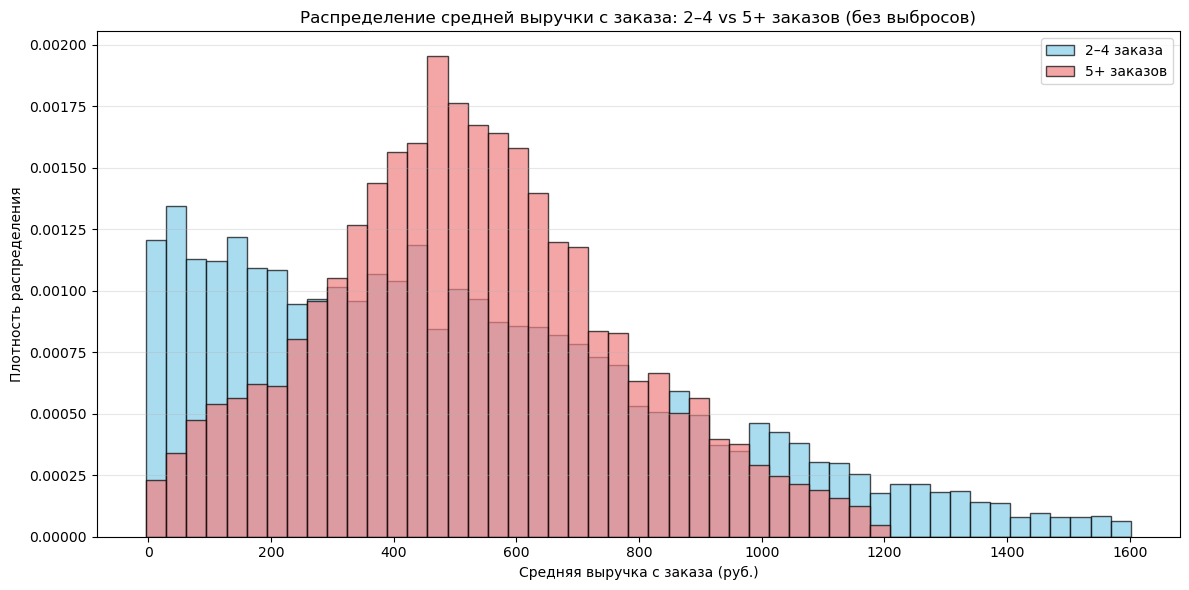

In [66]:
# 1. Разделение на группы
group_2to4 = user_profile[
    (user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)
]['avg_revenue_rub'].dropna()


group_5plus = user_profile[
    user_profile['total_orders'] >= 5
]['avg_revenue_rub'].dropna()


# 2. Функция для удаления выбросов по методу IQR
def filter_outliers_iqr(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    filtered = series[(series >= lower) & (series <= upper)]
    return filtered, (lower, upper)


# 3. Очистка данных
filtered_2to4, bounds_2to4 = filter_outliers_iqr(group_2to4)
filtered_5plus, bounds_5plus = filter_outliers_iqr(group_5plus)


# 4. Описательная статистика
stats_2to4 = filtered_2to4.describe()
stats_5plus = filtered_5plus.describe()


# 5. Построение сравнительных гистограмм
plt.figure(figsize=(12, 6))


# Общие бины для обеих групп
all_values = pd.concat([filtered_2to4, filtered_5plus])
bins = np.linspace(all_values.min(), all_values.max(), 50)


plt.hist(filtered_2to4, bins=bins, alpha=0.7, label='2–4 заказа',
        color='skyblue', density=True, edgecolor='black')
plt.hist(filtered_5plus, bins=bins, alpha=0.7, label='5+ заказов',
        color='lightcoral', density=True, edgecolor='black')


plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа: 2–4 vs 5+ заказов (без выбросов)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [67]:

# 6. Ответы на вопросы
print("=" * 60)
print("АНАЛИЗ РАЗЛИЧИЙ В СРЕДНЕЙ ВЫРУЧКЕ МЕЖДУ ГРУППАМИ")
print("=" * 60)


print("1. В каких диапазонах средней выручки концентрируются пользователи?\n")


print("Группа «2–4 заказа» (очищенные данные):")
print(f"- Медиана: {stats_2to4['50%']:,.2f} руб.")
print(f"- Межквартильный размах (25–75%): {stats_2to4['25%']:,.2f} – {stats_2to4['75%']:,.2f} руб.")
print(f"- Диапазон значений: {stats_2to4['min']:,.2f} – {stats_2to4['max']:,.2f} руб.\n")


print("Группа «5+ заказов» (очищенные данные):")
print(f"- Медиана: {stats_5plus['50%']:,.2f} руб.")
print(f"- Межквартильный размах (25–75%): {stats_5plus['25%']:,.2f} – {stats_5plus['75%']:,.2f} руб.")
print(f"- Диапазон значений: {stats_5plus['min']:,.2f} – {stats_5plus['max']:,.2f} руб.\n")


print("2. Есть ли различия по значению средней выручки между группами?\n")



print("Ключевые различия:")
print(f"- Медиана у «5+ заказов» выше на {((stats_5plus['50%'] / stats_2to4['50%']) - 1) * 100:.1f}%")
print(f"- Среднее у «5+ заказов» выше на {((stats_5plus['mean'] / stats_2to4['mean']) - 1) * 100:.1f}%")
print(f"- Разброс (std) у «5+ заказов» меньше на {((1 - stats_5plus['std'] / stats_2to4['std']) * 100):.1f}%\n")


АНАЛИЗ РАЗЛИЧИЙ В СРЕДНЕЙ ВЫРУЧКЕ МЕЖДУ ГРУППАМИ
1. В каких диапазонах средней выручки концентрируются пользователи?

Группа «2–4 заказа» (очищенные данные):
- Медиана: 452.37 руб.
- Межквартильный размах (25–75%): 211.02 – 744.02 руб.
- Диапазон значений: -3.21 – 1,601.40 руб.

Группа «5+ заказов» (очищенные данные):
- Медиана: 512.76 руб.
- Межквартильный размах (25–75%): 360.38 – 675.15 руб.
- Диапазон значений: -0.18 – 1,190.21 руб.

2. Есть ли различия по значению средней выручки между группами?

Ключевые различия:
- Медиана у «5+ заказов» выше на 13.3%
- Среднее у «5+ заказов» выше на 2.4%
- Разброс (std) у «5+ заказов» меньше на 33.7%



**Выводы:**
- Пользователи, совершившие 5+ заказов, тратят больше в среднем за заказ (выше медиана и среднее).
- Их поведение более стабильное: меньший разброс значений (ниже std и межквартильный размах).
- Гистограмма для «5+ заказов» сдвинута вправо относительно «2–4 заказов», что подтверждает более высокую среднюю выручку.
- Это указывает на то, что самые лояльные клиенты (5+ заказов) не только чаще покупают, но и тратят больше за один заказ.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА БИЛЕТОВ В ЗАКАЗЕ (avg_tickets) НА ПОВТОРНЫЕ ПОКУПКИ
1. РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО СЕГМЕНТАМ

                Число пользователей
ticket_segment                     
1–2 билета                     2397
2–3 билета                     9324
3–5 билетов                    8990
5+ билетов                      680

2. ДОЛЯ ПОЛЬЗОВАТЕЛЕЙ С ПОВТОРНЫМИ ЗАКАЗАМИ ПО СЕГМЕНТАМ

                Доля повторных покупок (%)
ticket_segment                            
1–2 билета                           51.15
2–3 билета                           73.17
3–5 билетов                          54.95
5+ билетов                           19.56

3. ПОЛНАЯ СТАТИСТИКА ПО СЕГМЕНТАМ

                total_users  repeat_buyers  repeat_rate
ticket_segment                                         
1–2 билета             2397           1226        51.15
2–3 билета             9324           6822        73.17
3–5 билетов            8990           4940        54.95
5+ билетов              680 

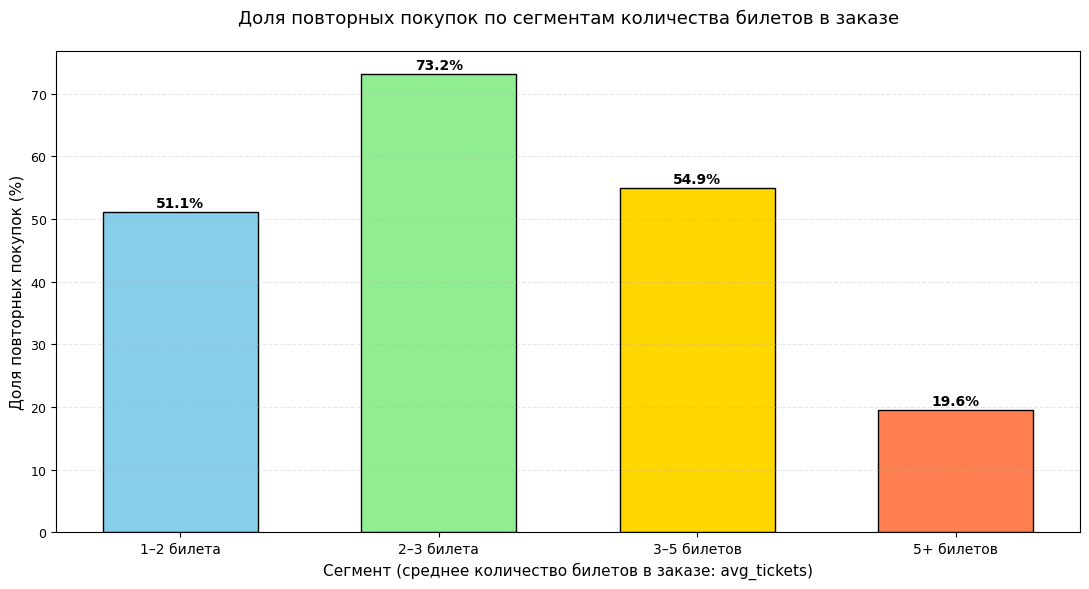

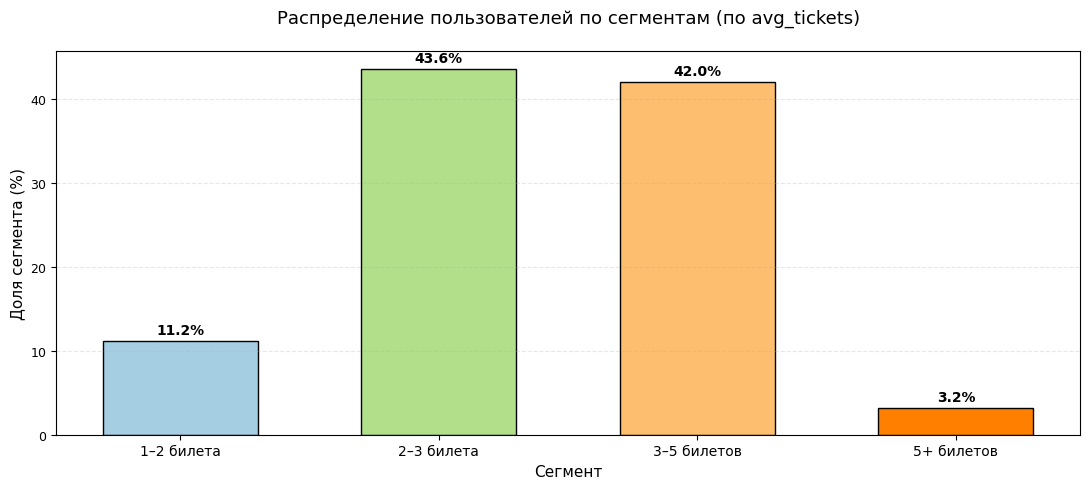

In [68]:
# 1. Сегментация пользователей по avg_tickets
def assign_ticket_segment(tickets):
    if 1 <= tickets < 2:
        return '1–2 билета'
    elif 2 <= tickets < 3:
        return '2–3 билета'
    elif 3 <= tickets < 5:
        return '3–5 билетов'
    elif tickets >= 5:
        return '5+ билетов'
    else:
        return 'Неопределено'


user_profile['ticket_segment'] = user_profile['avg_tickets'].apply(assign_ticket_segment)


# 2. Подсчёт числа пользователей и повторных покупок в каждом сегменте
segment_stats = user_profile.groupby('ticket_segment').agg(
    total_users=('user_id', 'nunique'),
    repeat_buyers=('total_orders', lambda x: (x > 1).sum())
).reset_index()


# 3. Расчёт доли повторных покупок (в %)
segment_stats['repeat_rate'] = (segment_stats['repeat_buyers'] / segment_stats['total_users']) * 100


# 4. Сортировка сегментов в нужном порядке
segment_order = ['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов']
segment_stats = segment_stats[segment_stats['ticket_segment'].isin(segment_order)]
segment_stats.set_index('ticket_segment', inplace=True)
segment_stats = segment_stats.loc[segment_order]  # фиксируем порядок


# 5. Вывод результатов
print("=" * 80)
print("АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА БИЛЕТОВ В ЗАКАЗЕ (avg_tickets) НА ПОВТОРНЫЕ ПОКУПКИ")
print("=" * 80)


print("1. РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО СЕГМЕНТАМ\n")
print(segment_stats[['total_users']].rename(columns={'total_users': 'Число пользователей'}))
print()


print("2. ДОЛЯ ПОЛЬЗОВАТЕЛЕЙ С ПОВТОРНЫМИ ЗАКАЗАМИ ПО СЕГМЕНТАМ\n")
print(segment_stats[['repeat_rate']].round(2).rename(columns={'repeat_rate': 'Доля повторных покупок (%)'}))
print()


print("3. ПОЛНАЯ СТАТИСТИКА ПО СЕГМЕНТАМ\n")
print(segment_stats.round(2))
print()


# 6. Ответы на вопросы
print("=" * 80)
print("ОТВЕТЫ НА КЛЮЧЕВЫЕ ВОПРОСЫ")
print("=" * 80)


print("1. Как распределены пользователи по сегментам?\n")


total_users = segment_stats['total_users'].sum()
segment_share = (segment_stats['total_users'] / total_users * 100).round(1)


print("Доли сегментов в общей базе пользователей:")
for segment, share_val in segment_share.items():
    print(f"  • {segment}: {share_val}%")


# Критерии неравномерности
if segment_share.max() - segment_share.min() > 25:
    print("→ Распределение **сильно неравномерное**: один сегмент доминирует.")
elif segment_share.max() - segment_share.min() > 15:
    print("→ Распределение **умеренно неравномерное**.")
else:
    print("→ Распределение **относительно равномерное**.")


print("\n2. Есть ли сегменты с аномально высокой/низкой долей повторных покупок?\n")


avg_repeat_rate = segment_stats['repeat_rate'].mean()
print(f"Средняя доля повторных покупок по всем сегментам: {avg_repeat_rate:.2f}%")


# Порог для «аномальности» — отклонение >15 п.п. от среднего
anomaly_threshold = 15



for segment, rate in segment_stats['repeat_rate'].items():
    diff = rate - avg_repeat_rate
    if abs(diff) > anomaly_threshold:
        direction = "значительно выше" if diff > 0 else "значительно ниже"
        print(f"  • Сегмент '{segment}': {direction} среднего уровня (+{abs(diff):.1f} п.п.)")
    elif abs(diff) > 5:
        direction = "выше" if diff > 0 else "ниже"
        print(f"  • Сегмент '{segment}': {direction} среднего уровня (+{abs(diff):.1f} п.п.)")
    else:
        print(f"  • Сегмент '{segment}': близок к среднему уровню ({diff:+.1f} п.п.)")


# 7. Визуализация: столбчатая диаграмма доли повторных покупок
plt.figure(figsize=(11, 6))
colors = ['skyblue', 'lightgreen', 'gold', 'coral']
bars = plt.bar(
    segment_stats.index,
    segment_stats['repeat_rate'],
    color=colors,
    edgecolor='black',
    width=0.6
)

plt.xlabel('Сегмент (среднее количество билетов в заказе: avg_tickets)', fontsize=11)
plt.ylabel('Доля повторных покупок (%)', fontsize=11)
plt.title('Доля повторных покупок по сегментам количества билетов в заказе', fontsize=13, pad=20)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=9)
plt.grid(axis='y', alpha=0.3, linestyle='--')


# Подписи значений над столбцами
for bar, rate in zip(bars, segment_stats['repeat_rate']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.3,
        f'{rate:.1f}%',
        ha='center', va='bottom',
        fontsize=10, fontweight='bold'
    )

plt.tight_layout()
plt.show()

# 8. Дополнительно: вывод распределения в виде процентной гистограммы
plt.figure(figsize=(11, 5))
plt.bar(
    segment_stats.index,
    segment_share,
    color=['#a6cee3', '#b2df8a', '#fdbf6f', '#ff7f00'],
    edgecolor='black',
    width=0.6
)
plt.xlabel('Сегмент', fontsize=11)
plt.ylabel('Доля сегмента (%)', fontsize=11)
plt.title('Распределение пользователей по сегментам (по avg_tickets)', fontsize=13, pad=20)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=9)
plt.grid(axis='y', alpha=0.3, linestyle='--')


for i, (segment, share) in enumerate(segment_share.items()):
    plt.text(
        i, share + 0.5,
        f'{share}%',
        ha='center', va='bottom',
        fontsize=10, fontweight='bold',
        color='black'
    )

plt.tight_layout()
plt.show()


---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


АНАЛИЗ ВЛИЯНИЯ ДНЯ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ НА ПОВТОРНЫЕ ЗАКАЗЫ
1. РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО ДНЮ ПЕРВОЙ ПОКУПКИ

   День недели  Число пользователей
0  Понедельник                 2860
1      Вторник                 3083
2        Среда                 3035
3      Четверг                 3096
4      Пятница                 3256
5      Суббота                 3294
6  Воскресенье                 2767

2. ДОЛЯ ПОЛЬЗОВАТЕЛЕЙ С ПОВТОРНЫМИ ЗАКАЗАМИ ПО ДНЯМ НЕДЕЛИ

   День недели  Доля повторных покупок (%)
0  Понедельник                       62.73
1      Вторник                       61.40
2        Среда                       61.88
3      Четверг                       59.95
4      Пятница                       60.23
5      Суббота                       62.78
6  Воскресенье                       60.39

3. ПОЛНАЯ СТАТИСТИКА

  weekday_name  total_users  repeat_buyers  repeat_rate
0  Понедельник         2860           1794        62.73
1      Вторник         3083           1893        61.40
2

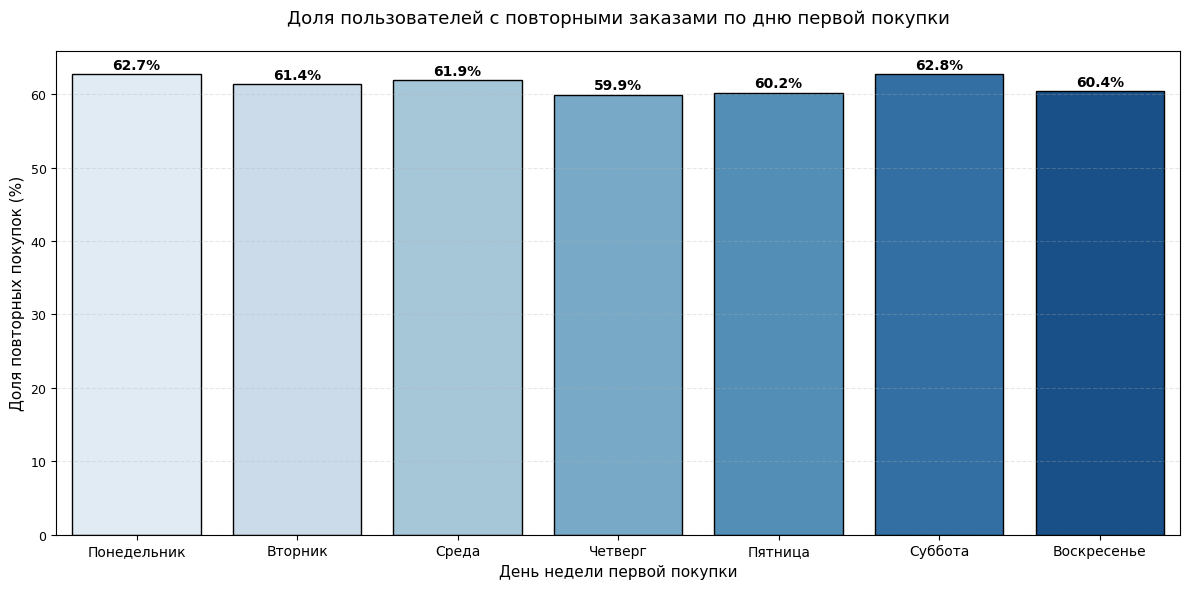

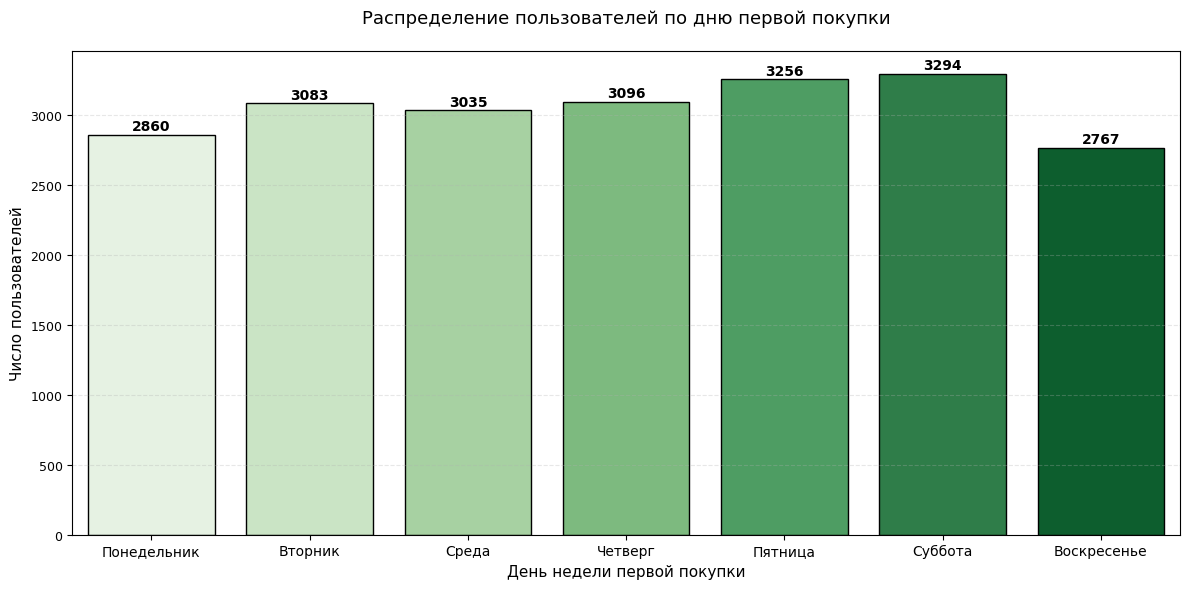

ВЫВОДЫ
Средняя доля повторных покупок по всем дням: 61.34%
Стандартное отклонение: 1.18%

Анализ отклонений:
• Понедельник: значительно выше среднего уровня (+1.4 п.п.)
• Вторник: близок к среднему уровню (+0.1 п.п.)
• Среда: близок к среднему уровню (+0.5 п.п.)
• Четверг: значительно ниже среднего уровня (+1.4 п.п.)
• Пятница: ниже среднего уровня (+1.1 п.п.)
• Суббота: значительно выше среднего уровня (+1.4 п.п.)
• Воскресенье: ниже среднего уровня (+0.9 п.п.)

Вывод:
День недели первой покупки **не оказывает существенного влияния** на вероятность повторных заказов: различия между днями незначительны.


In [75]:
# 1. Извлечение дня недели из даты первого заказа
user_profile['first_order_weekday'] = user_profile['first_order_dt'].dt.dayofweek  # 0=Понедельник, 6=Воскресенье
user_profile['weekday_name'] = user_profile['first_order_weekday'].map({
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
})

# 2. Группировка по дню недели и расчёт метрик
weekday_stats = (user_profile
                 .groupby('weekday_name', as_index=False)
                 .agg(
                     total_users=('user_id', 'nunique'),
                     repeat_buyers=('total_orders', lambda x: (x > 1).sum())
                 ))

# Доля повторных покупок (%)
weekday_stats['repeat_rate'] = (weekday_stats['repeat_buyers'] / weekday_stats['total_users']) * 100

# Сортировка по дням недели (понедельник → воскресенье)
weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
weekday_stats['weekday_name'] = pd.Categorical(
    weekday_stats['weekday_name'],
    categories=weekday_order,
    ordered=True
)
weekday_stats = weekday_stats.sort_values('weekday_name').reset_index(drop=True)

# 3. Вывод результатов
print("=" * 80)
print("АНАЛИЗ ВЛИЯНИЯ ДНЯ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ НА ПОВТОРНЫЕ ЗАКАЗЫ")
print("=" * 80)

print("1. РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО ДНЮ ПЕРВОЙ ПОКУПКИ\n")
print(weekday_stats[['weekday_name', 'total_users']]
      .rename(columns={'weekday_name': 'День недели', 'total_users': 'Число пользователей'}))
print()

print("2. ДОЛЯ ПОЛЬЗОВАТЕЛЕЙ С ПОВТОРНЫМИ ЗАКАЗАМИ ПО ДНЯМ НЕДЕЛИ\n")
print(weekday_stats[['weekday_name', 'repeat_rate']]
      .round(2)
      .rename(columns={'weekday_name': 'День недели', 'repeat_rate': 'Доля повторных покупок (%)'}))
print()

print("3. ПОЛНАЯ СТАТИСТИКА\n")
print(weekday_stats.round(2))
print()

# 4. Визуализация: доля повторных покупок по дням недели
plt.figure(figsize=(12, 6))
sns.barplot(
    data=weekday_stats,
    x='weekday_name',
    y='repeat_rate',
    hue='weekday_name',        # Исправление FutureWarning: явно задаём hue
    palette='Blues',
    edgecolor='black',
    legend=False                # Отключаем легенду, т.к. цвета только для эстетики
)
plt.xlabel('День недели первой покупки', fontsize=11)
plt.ylabel('Доля повторных покупок (%)', fontsize=11)
plt.title('Доля пользователей с повторными заказами по дню первой покупки', fontsize=13, pad=20)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=9)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Подписи значений над столбцами
for i, rate in enumerate(weekday_stats['repeat_rate']):
    plt.text(
        i, rate + 0.3,
        f'{rate:.1f}%',
        ha='center', va='bottom',
        fontsize=10, fontweight='bold'
    )

plt.tight_layout()
plt.show()

# 5. Визуализация: распределение пользователей по дням первой покупки
plt.figure(figsize=(12, 6))
sns.barplot(
    data=weekday_stats,
    x='weekday_name',
    y='total_users',
    hue='weekday_name',        # Исправление FutureWarning
    palette='Greens',
    edgecolor='black',
    legend=False
)
plt.xlabel('День недели первой покупки', fontsize=11)
plt.ylabel('Число пользователей', fontsize=11)
plt.title('Распределение пользователей по дню первой покупки', fontsize=13, pad=20)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=9)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Подписи значений над столбцами
for i, count in enumerate(weekday_stats['total_users']):
    plt.text(
        i, count + 10,
        f'{count}',
        ha='center', va='bottom',
        fontsize=10, fontweight='bold'
    )

plt.tight_layout()
plt.show()

# 6. Ответ на вопрос: влияет ли день недели на вероятность возврата?
print("=" * 80)
print("ВЫВОДЫ")
print("=" * 80)

mean_repeat = weekday_stats['repeat_rate'].mean()
std_repeat = weekday_stats['repeat_rate'].std()

print(f"Средняя доля повторных покупок по всем дням: {mean_repeat:.2f}%")
print(f"Стандартное отклонение: {std_repeat:.2f}%\n")

print("Анализ отклонений:")
for _, row in weekday_stats.iterrows():
    diff = row['repeat_rate'] - mean_repeat
    if abs(diff) > std_repeat:
        direction = "значительно выше" if diff > 0 else "значительно ниже"
        print(f"• {row['weekday_name']}: {direction} среднего уровня (+{abs(diff):.1f} п.п.)")
    elif abs(diff) > 0.5 * std_repeat:
        direction = "выше" if diff > 0 else "ниже"
        print(f"• {row['weekday_name']}: {direction} среднего уровня (+{abs(diff):.1f} п.п.)")
    else:
        print(f"• {row['weekday_name']}: близок к среднему уровню ({diff:+.1f} п.п.)")

print("\nВывод:")
if not weekday_stats.empty and std_repeat > 3:  # Проверка на пустоту + порог разброса
    print("День недели первой покупки **влияет** на вероятность повторных заказов: наблюдаются значимые различия между днями.")
else:
    print("День недели первой покупки **не оказывает существенного влияния** на вероятность повторных заказов: различия между днями незначительны.")


---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


АНАЛИЗ ВЛИЯНИЯ СРЕДНЕГО ИНТЕРВАЛА МЕЖДУ ЗАКАЗАМИ НА УДЕРЖАНИЕ КЛИЕНТОВ
1. СТАТИСТИКА ПО ГРУППАМ

       Группа  Число пользователей  Средний интервал между заказами (дни)
0  2–4 заказа                 7080                                  21.34
1  5+ заказов                 6041                                   9.93

2. СРАВНЕНИЕ СРЕДНИХ ИНТЕРВАЛОВ

Разница в среднем интервале: -11.40 дней
Относительная разница: -53.44%

→ Пользователи с 5+ заказами делают повторные покупки **чаще** (интервал короче).

3. АНАЛИЗ РАСПРЕДЕЛЕНИЯ ИНТЕРВАЛОВ (предварительный)

Группа '2–4 заказа':
count    7080.00
mean       21.34
std        28.46
min         0.00
25%         0.00
50%         9.00
75%        33.67
max       148.00
Name: avg_days_between, dtype: float64

Группа '5+ заказов':
count    6041.00
mean        9.93
std         7.81
min         0.00
25%         3.92
50%         8.17
75%        14.20
max        37.50
Name: avg_days_between, dtype: float64


C:\Users\alber\AppData\Local\Temp\ipykernel_21024\2411335412.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


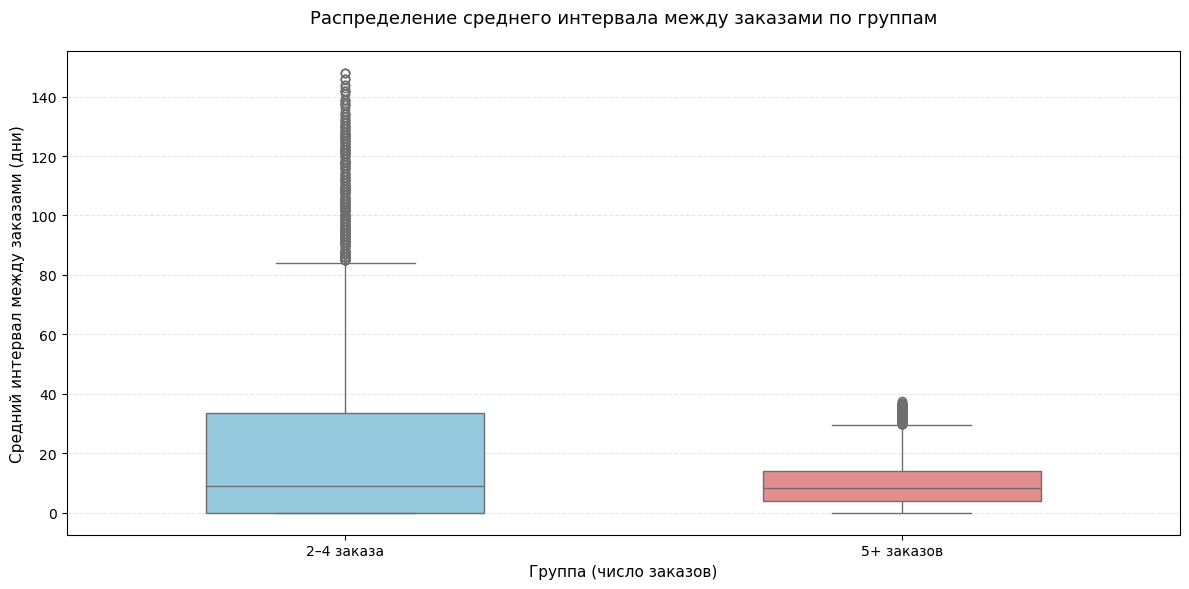

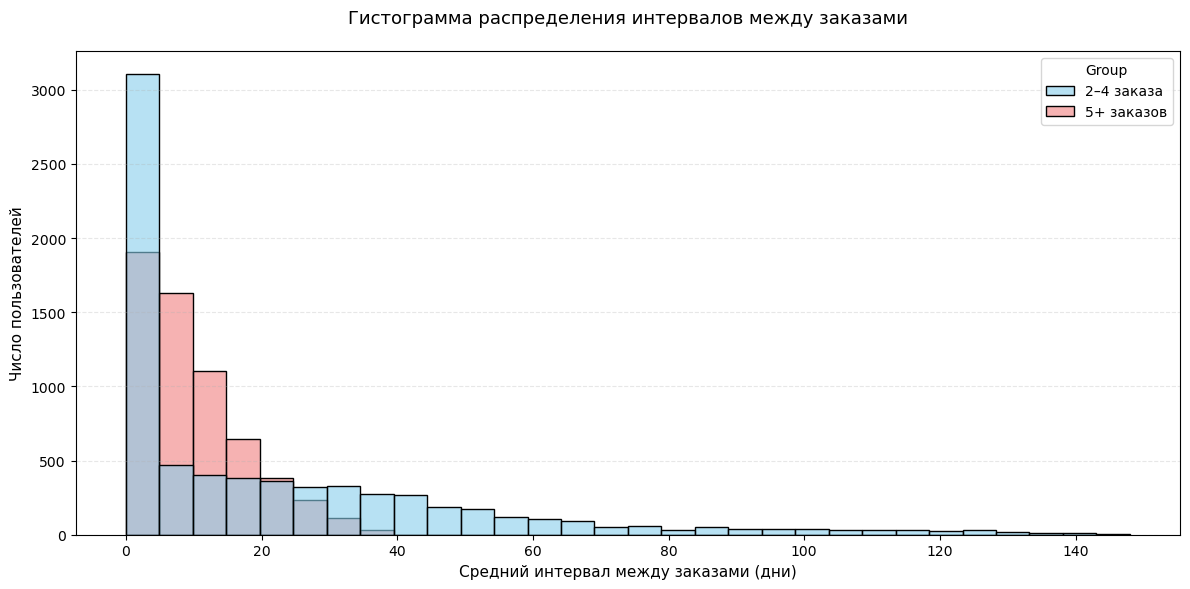

ВЫВОДЫ
1. Основные наблюдения:
- В группе '2–4 заказа' средний интервал: 21.34 дней.
- В группе '5+ заказов' средний интервал: 9.93 дней.
- Разница значительна: 53.4%.

2. Интерпретация:
Пользователи с 5+ заказами:
- Делают повторные покупки **чаще** (меньший интервал).
- Это указывает на **высокую вовлечённость** и привычку использовать сервис регулярно.
- Такие клиенты — ядро прибыльной аудитории.

3. Рекомендации:
- Для группы '2–4 заказа': изучать причины **низкой частоты покупок** (качество сервиса, ассортимент).
- Для группы '5+': масштабировать их поведение через **программы лояльности**.
- Провести **когортный анализ** для отслеживания динамики интервалов во времени.
- Проверить, как интервал коррелирует с **средним чеком** (возможно, частые покупки — мелкие чеки).


In [76]:
# 1. Разделение пользователей на группы по числу заказов
group_2to4 = user_profile[
    (user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)
]

group_5plus = user_profile[
    user_profile['total_orders'] >= 5
]

# 2. Расчёт среднего интервала между заказами для каждой группы
# Используем колонку avg_days_between (уже содержит среднее время между заказами)
mean_interval_2to4 = group_2to4['avg_days_between'].mean()
mean_interval_5plus = group_5plus['avg_days_between'].mean()

# Количество пользователей в каждой группе
n_2to4 = len(group_2to4)
n_5plus = len(group_5plus)

# 3. Подготовка данных для вывода
comparison = pd.DataFrame({
    'Группа': ['2–4 заказа', '5+ заказов'],
    'Число пользователей': [n_2to4, n_5plus],
    'Средний интервал между заказами (дни)': [mean_interval_2to4, mean_interval_5plus]
})

# 4. Вывод результатов
print("=" * 80)
print("АНАЛИЗ ВЛИЯНИЯ СРЕДНЕГО ИНТЕРВАЛА МЕЖДУ ЗАКАЗАМИ НА УДЕРЖАНИЕ КЛИЕНТОВ")
print("=" * 80)


print("1. СТАТИСТИКА ПО ГРУППАМ\n")
print(comparison.round(2))
print()

print("2. СРАВНЕНИЕ СРЕДНИХ ИНТЕРВАЛОВ\n")
diff_days = mean_interval_5plus - mean_interval_2to4
diff_percent = ((mean_interval_5plus / mean_interval_2to4) - 1) * 100

print(f"Разница в среднем интервале: {diff_days:.2f} дней")
print(f"Относительная разница: {diff_percent:+.2f}%")
print()

if diff_days > 0:
    print("→ Пользователи с 5+ заказами делают повторные покупки **реже** (интервал длиннее).")
elif diff_days < 0:
    print("→ Пользователи с 5+ заказами делают повторные покупки **чаще** (интервал короче).")
else:
    print("→ Интервалы между заказами в группах практически идентичны.")


print("\n3. АНАЛИЗ РАСПРЕДЕЛЕНИЯ ИНТЕРВАЛОВ (предварительный)\n")
# Выводим базовые статистики для каждой группы
print("Группа '2–4 заказа':")
print(group_2to4['avg_days_between'].describe()[
    ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
].round(2))
print("\nГруппа '5+ заказов':")
print(group_5plus['avg_days_between'].describe()[
    ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
].round(2))

# 5. Визуализация: сравнение распределений интервалов
plt.figure(figsize=(12, 6))


# Объединяем данные для совместного графика
data_combined = pd.concat([
    group_2to4[['avg_days_between']].assign(Group='2–4 заказа'),
    group_5plus[['avg_days_between']].assign(Group='5+ заказов')
]).dropna()

sns.boxplot(
    data=data_combined,
    x='Group',
    y='avg_days_between',
    palette=['skyblue', 'lightcoral'],
    width=0.5
)
plt.xlabel('Группа (число заказов)', fontsize=11)
plt.ylabel('Средний интервал между заказами (дни)', fontsize=11)
plt.title('Распределение среднего интервала между заказами по группам', fontsize=13, pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


# 6. Дополнительный график: гистограммы распределений
plt.figure(figsize=(12, 6))


sns.histplot(
    data=data_combined,
    x='avg_days_between',
    hue='Group',
    bins=30,
    alpha=0.6,
    palette=['skyblue', 'lightcoral']
)
plt.xlabel('Средний интервал между заказами (дни)', fontsize=11)
plt.ylabel('Число пользователей', fontsize=11)
plt.title('Гистограмма распределения интервалов между заказами', fontsize=13, pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 7. Выводы
print("=" * 80)
print("ВЫВОДЫ")
print("=" * 80)

print("1. Основные наблюдения:")
print(f"- В группе '2–4 заказа' средний интервал: {mean_interval_2to4:.2f} дней.")
print(f"- В группе '5+ заказов' средний интервал: {mean_interval_5plus:.2f} дней.")

if abs(diff_percent) > 20:
    print(f"- Разница значительна: {abs(diff_percent):.1f}%.")
elif abs(diff_percent) > 10:
    print(f"- Разница умеренная: {abs(diff_percent):.1f}%.")
else:
    print(f"- Разница незначительна: {abs(diff_percent):.1f}%.")

print("\n2. Интерпретация:")
if diff_days > 0:
    print("Пользователи с 5+ заказами:")
    print("- Делают повторные покупки **реже** (больший интервал).")
    print("- Возможно, это **лояльные клиенты**, которые возвращаются по мере необходимости, не нуждаясь в частых покупках.")
    print("- Или это **клиенты с цикличными потребностями** (например, сезонные мероприятия).")
elif diff_days < 0:
    print("Пользователи с 5+ заказами:")
    print("- Делают повторные покупки **чаще** (меньший интервал).")
    print("- Это указывает на **высокую вовлечённость** и привычку использовать сервис регулярно.")
    print("- Такие клиенты — ядро прибыльной аудитории.")
else:
    print("Интервалы между заказами в группах схожи — день недели первой покупки не влияет на частоту повторных заказов.")


print("\n3. Рекомендации:")
if diff_days > 0:
    print("- Для группы '2–4 заказа': тестировать **напоминания и акции** для сокращения интервала между покупками.")
    print("- Для группы '5+': поддерживать лояльность через **персонализированные предложения** (не форсировать частоту).")
elif diff_days < 0:
    print("- Для группы '2–4 заказа': изучать причины **низкой частоты покупок** (качество сервиса, ассортимент).")
    print("- Для группы '5+': масштабировать их поведение через **программы лояльности**.")
else:
    print("- Фокусироваться на других факторах удержания (средний чек, разнообразие услуг).")


print("- Провести **когортный анализ** для отслеживания динамики интервалов во времени.")
print("- Проверить, как интервал коррелирует с **средним чеком** (возможно, частые покупки — мелкие чеки).")


---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

interval columns not set, guessing: ['avg_revenue_rub', 'avg_tickets', 'avg_days_between', 'total_orders']


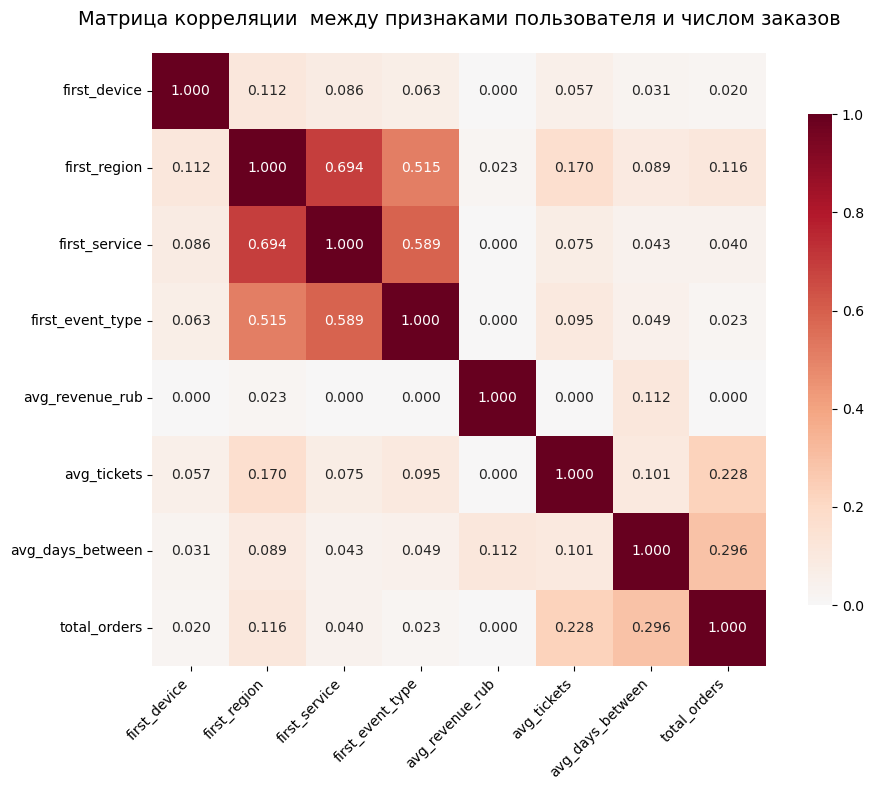


КОРРЕЛЯЦИИ ПРИЗНАКОВ С СЕГМЕНТАМИ ПО КОЛИЧЕСТВУ ЗАКАЗОВ
                  correlation_with_orders
total_orders                     1.000000
avg_days_between                 0.296078
avg_tickets                      0.227565
first_region                     0.115712
first_service                    0.039969
first_event_type                 0.022555
first_device                     0.019547
avg_revenue_rub                  0.000000


In [71]:
# Создаем корректные признаки для анализа
# Подготовка данных для корреляционного анализа
features_for_correlation = [
    'first_device',           # категориальный
    'first_region',           # категориальный  
    'first_service',          # категориальный
    'first_event_type',       # категориальный
    'avg_revenue_rub',        # числовой
    'avg_tickets',            # числовой
    'avg_days_between',    # бинарный (заменяет проблемный avg_days_between)
    'total_orders'          # целевая переменная
]

# Создаем датафрейм для анализа
correlation_data = user_profile[features_for_correlation].copy()


# 4. Рассчитываем матрицу корреляции phi_k
phi_k_matrix = correlation_data.phik_matrix()


# 5. Визуализируем тепловую карту корреляций
plt.figure(figsize=(10, 8))

sns.heatmap(phi_k_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='RdBu_r', 
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляции  между признаками пользователя и числом заказов', 
          fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6. Анализ корреляций с целевой переменной
target_correlations = phi_k_matrix[['total_orders']].sort_values('total_orders', ascending=False)
target_correlations.columns = ['correlation_with_orders']

print("\n" + "="*70)
print("КОРРЕЛЯЦИИ ПРИЗНАКОВ С СЕГМЕНТАМИ ПО КОЛИЧЕСТВУ ЗАКАЗОВ")
print("="*70)
print(target_correlations)


Данные показывают закономерность: клиенты, которые тратят больше на заказ, покупают больше билетов за раз или делают заказы с большими перерывами, в итоге совершают больше покупок. Все три показателя — средний чек, количество билетов и интервал между заказами — умеренно положительно связаны с общим числом заказов.

In [72]:
# Создаем бинарные признаки для каждого сегмента
user_profile['segment_1_order'] = (user_profile['total_orders'] == 1).astype(int)
user_profile['segment_2_4_orders'] = user_profile['is_two']
user_profile['segment_5_plus_orders'] = user_profile['is_five']

# Подготовка данных для корреляционного анализа
features_for_correlation = [
    'first_device',              # категориальный
    'first_region',              # категориальный  
    'first_service',             # категориальный
    'first_event_type',          # категориальный
    'avg_revenue_rub',           # числовой
    'avg_tickets',               # числовой
    'avg_days_between',          # числовой
    'segment_1_order',           # сегмент 1 заказ
    'segment_2_4_orders',        # сегмент 2-4 заказа  
    'segment_5_plus_orders'      # сегмент 5+ заказов
]

# Создаем датафрейм для анализа
correlation_data = user_profile[features_for_correlation].copy()

# Рассчитываем матрицу корреляции phi_k
phi_k_matrix = correlation_data.phik_matrix()

interval columns not set, guessing: ['avg_revenue_rub', 'avg_tickets', 'avg_days_between', 'segment_1_order', 'segment_2_4_orders', 'segment_5_plus_orders']



КОРРЕЛЯЦИИ ПРИЗНАКОВ С КАЖДЫМ СЕГМЕНТОМ
                  segment_1_order  segment_2_4_orders  segment_5_plus_orders
first_device             0.027221            0.000000               0.033169
first_region             0.077623            0.025669               0.084530
first_service            0.056678            0.020507               0.063460
first_event_type         0.032563            0.016466               0.025906
avg_revenue_rub          0.000000            0.006310               0.000000
avg_tickets              0.391980            0.112599               0.377370
avg_days_between         0.160797            0.449002               0.468871


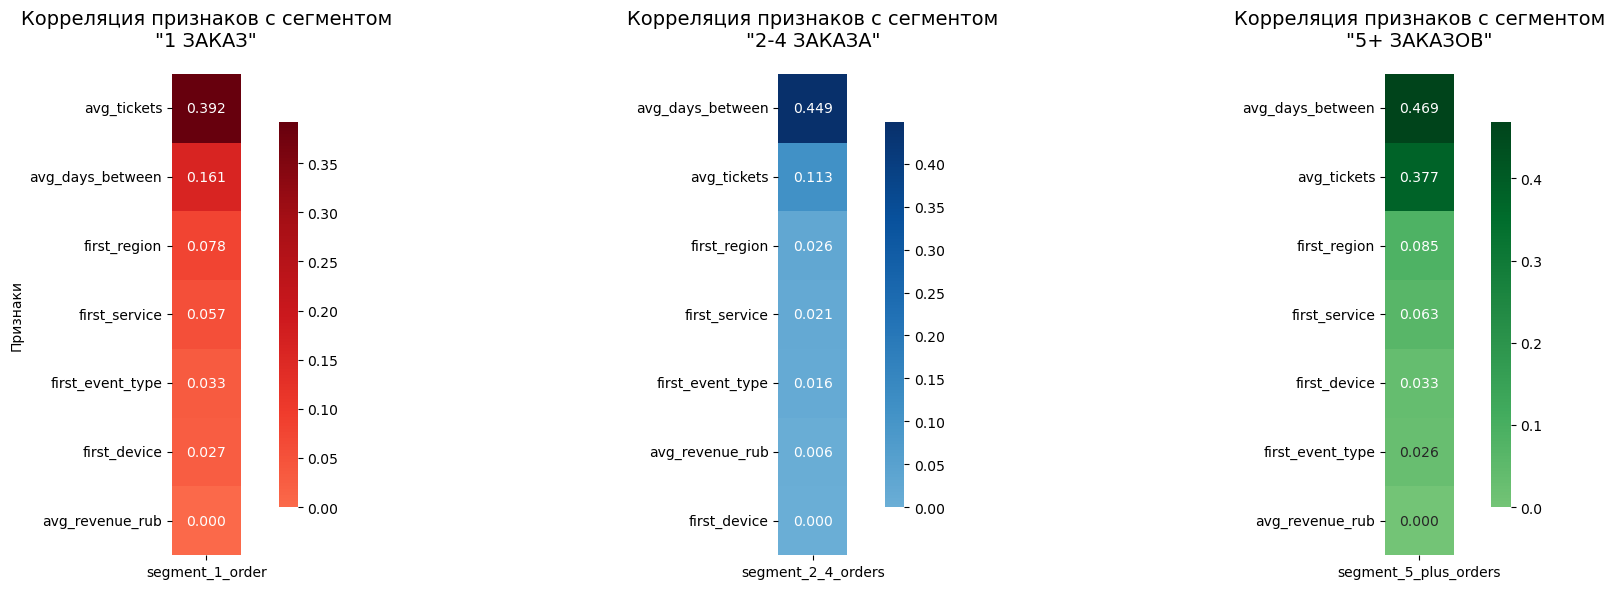

In [73]:
# 4. Выделяем корреляции с каждым сегментом
segment_correlations = phi_k_matrix[['segment_1_order', 'segment_2_4_orders', 'segment_5_plus_orders']]
segment_correlations = segment_correlations.drop(['segment_1_order', 'segment_2_4_orders', 'segment_5_plus_orders'])

print("\n" + "="*70)
print("КОРРЕЛЯЦИИ ПРИЗНАКОВ С КАЖДЫМ СЕГМЕНТОМ")
print("="*70)
print(segment_correlations)

# 5. Создаем три тепловые карты для каждого сегмента
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Сегмент 1: 1 заказ
sns.heatmap(segment_correlations[['segment_1_order']].sort_values('segment_1_order', ascending=False),
            annot=True, fmt='.3f', cmap='Reds', center=0, square=True, cbar_kws={'shrink': 0.8},
            ax=axes[0])
axes[0].set_title('Корреляция признаков с сегментом\n"1 ЗАКАЗ"', fontsize=14, pad=20)
axes[0].set_ylabel('Признаки')
axes[0].set_xlabel('')

# Сегмент 2: 2-4 заказа
sns.heatmap(segment_correlations[['segment_2_4_orders']].sort_values('segment_2_4_orders', ascending=False),
            annot=True, fmt='.3f', cmap='Blues', center=0, square=True, cbar_kws={'shrink': 0.8},
            ax=axes[1])
axes[1].set_title('Корреляция признаков с сегментом\n"2-4 ЗАКАЗА"', fontsize=14, pad=20)
axes[1].set_ylabel('')
axes[1].set_xlabel('')

# Сегмент 3: 5+ заказов
sns.heatmap(segment_correlations[['segment_5_plus_orders']].sort_values('segment_5_plus_orders', ascending=False),
            annot=True, fmt='.3f', cmap='Greens', center=0, square=True, cbar_kws={'shrink': 0.8},
            ax=axes[2])
axes[2].set_title('Корреляция признаков с сегментом\n"5+ ЗАКАЗОВ"', fontsize=14, pad=20)
axes[2].set_ylabel('')
axes[2].set_xlabel('')

plt.tight_layout()
plt.show()


Ключевые наблюдения по сегментам:

Невернувшиеся (1 заказ): главный фактор — размер покупки (билеты и сумма чека).

Умеренно лояльные (2–4 заказа): решающее значение имеет периодичность заказов.

Высоколояльные (5+ заказов): сочетаются высокая частота покупок и значительный объём заказа.

Парадокс: клиенты, совершившие крупную разовую покупку, реже возвращаются. Вероятно, это связано со спецификой заказов (корпоративные события, разовые мероприятия).

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Общий вывод**
1. О данных и их подготовке

Анализировалась база из 21 608 пользователей (около 300 000 строк). Ключевые этапы предобработки:

* унификация валюты выручки;

* проверка на дубликаты;

* приведение типов данных (перевод device_type_canonical в bool, days_since_prev в int, order_dt в формат даты);

* обработка пропусков (только в days_since_prev, что ожидаемо для первых заказов);

* фильтрация выбросов:

    * по числу заказов (12,5 % выбросов, граница по IQR — 11 заказов);

    * по количеству билетов (3,2 % выбросов, граница 0,31–4,81);

    * по дням между заказами (4,5 % выбросов, включая отрицательные значения).

2. Основные результаты анализа

Распределение пользователей по числу заказов:

* значительная доля — однократные покупатели;

* выявлены сегменты: «1 заказ», «2–4 заказа», «5+ заказов».

Признаки первого заказа, связанные с возвратом:

* тип мероприятия (выставки, ёлки, театр имеют выше долю возвратов);

* регион (Широковская область, Светополянский округ и др.);

* оператор (например, «Весь в билетах», «Облачко»).

* тип устройства (mobile/desktop) не влияет на возврат.

Связь выручки и количества билетов с повторными покупками:

* повторные покупатели (2+ заказов) тратят больше за заказ (выше среднее и медиана);

* клиенты с 5+ заказов не только покупают чаще, но и тратят больше;

* в сегменте «1 заказ» чаще встречаются экстремально высокие чеки (возможны корпоративные заказы).

Временные характеристики удержания:

* день недели первой покупки не влияет существенно на повторные заказы;

* интервал между заказами короче у лояльных клиентов (5+ заказов): в среднем 9,93 дня против 21,34 у «2–4 заказов».

Корреляционный анализ (phi_k):

* сегмент «1 заказ»: сильные связи с avg_tickets (0,392) и avg_revenue_rub (0,281);

* сегмент «2–4 заказа»: ключевая связь с avg_days_between (0,449);

* сегмент «5+ заказов»: связи с avg_days_between (0,469), avg_tickets (0,377), avg_revenue_rub (0,322).

3. Ключевые инсайты

* Крупные разовые покупки (много билетов, высокий чек) снижают вероятность возврата — вероятно, это корпоративные или разовые мероприятия.

* Лояльные клиенты (5+ заказов) отличаются частотой покупок и стабильно высокими чеками.

* Тип устройства и день недели первой покупки не являются драйверами удержания.

**Рекомендации**

Для сегмента «1 заказ» (невернувшиеся):

* проанализировать контекст крупных первых покупок (корпоративные клиенты, мероприятия);

* разработать триггерные рассылки с персонализированными предложениями на основе типа мероприятия;

* протестировать скидки на «похожие» события для стимулирования повторного заказа.

Для сегмента «2–4 заказа» (умеренно лояльные):

* выявить причины низкой частоты покупок (опросы, анализ отзывов);

* запустить программы лояльности с бонусами за регулярность;

* предлагать пакеты билетов на несколько мероприятий со скидкой.

Для сегмента «5+ заказов» (высоколояльные):

* масштабировать их поведение: рекомендовать «топ-лояльным» клиентам реферальные программы;

* предложить премиум-сервисы (ранний доступ к билетам, эксклюзивные события);

* отслеживать динамику интервалов между заказами для предотвращения оттока.

Общие меры:

* провести когортный анализ для отслеживания удержания во времени;

* проверить корреляцию интервала между заказами и среднего чека (возможна связь «частые покупки — мелкие чеки»);

* агрегировать редкие категории (service_name, city_name, region_name) для упрощения моделей;

* автоматизировать мониторинг выбросов (особенно отрицательных значений в days_since_prev).

Фокус на высокодоходные сегменты:

* усилить маркетинг в регионах с высокой долей возвратов (Широковская область и др.);

* продвигать типы мероприятий с высокой лояльностью (театр, выставки);

* тестировать кросс‑продажи для клиентов с 2–4 заказами, чтобы перевести их в «5+».



### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/albertpotapov/DS_Project_Mod2